# Library

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from dataclasses import dataclass
from pprint import pformat
# from loguru import logger
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# %pip install nbformat
# %pip install nbconvert

## Numpy set seed

In [3]:
np.random.seed(42)

## Part 1

In [4]:
# Load the npy file
# You can use numpy's load function to read .npy files
npy_data : np.ndarray= np.load('./weights.npy', allow_pickle=True)

In [5]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # Numerical stability
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)


def softmax_derivative(softmax_output):
    # The derivative of softmax is generally used with cross-entropy loss, but for this example:
    s = softmax_output.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)


In [6]:
class Tools:
    activate_funcs = {
        "sigmoid": (
            lambda x: 1 / (1 + np.exp(-x)),
            lambda x: 1 / (1 + np.exp(-x) ** 2),
        ),
        "relu": (lambda x: np.maximum(0, x), lambda x: np.where(x > 0, 1, 0)),
        "leaky_relu": (
            lambda x: np.where(x > 0, x, x * 0.01),
            lambda x: np.where(x > 0, 1, 0.01),
        ),
        "tanh": (lambda x: np.tanh(x), lambda x: 1 - np.tanh(x) ** 2),
        "linear": (lambda x: x, lambda x: 1),
        "softmax": (
            lambda x: np.clip(softmax(x), 1e-15, 1 - 1e-15),
            softmax_derivative,
        ),
    }

    loss_funcs = {
        "sse": (
            lambda y, y_hat: np.sum((y - y_hat) ** 2),
            lambda y, y_hat: -2 * (y - y_hat),
        ),
        "rms": (
            lambda y, y_hat: np.sqrt(np.mean((y - y_hat) ** 2)),
            lambda y, y_hat: -(y - y_hat) / (len(y) * np.sqrt(np.sum((y - y_hat) ** 2))),
        ),
        "crossentropy": (
            lambda y, y_hat: -np.sum(y * np.log(y_hat)),
            lambda y, y_hat: y_hat - y,
        )
    }

    @staticmethod
    def activate_func(name: str) -> tuple[Callable, Callable]:
        return Tools.activate_funcs[name]

    @staticmethod
    def loss_func(name: str) -> tuple[Callable, Callable]:
        return Tools.loss_funcs[name]

    @staticmethod
    def rms(y_true: np.ndarray, y_hat: np.ndarray) -> float:
        return np.sqrt(np.mean(np.sum(y_true - y_hat) ** 2))

In [7]:
@dataclass
class Layer:
    input_node: int
    activate: str
    output_node: int
    dropout_rate: float = 0.0
    zero:bool = False
    dtype: np.dtype = np.float32


@dataclass
class BaseModelLayer:
    w: np.ndarray
    b: np.ndarray

    @classmethod
    def zero_like(cls, layer_basic):
        w = np.zeros_like(layer_basic.w)
        b = np.zeros_like(layer_basic.b)
        return cls(w, b)

    @property
    def shape(self) -> dict:
        return {"w": self.w.shape, "b": self.b.shape}

In [8]:


@dataclass
class ModelLayer(BaseModelLayer):
    activate_str: str
    activate: Callable[[np.ndarray], np.ndarray]
    activate_derivative: Callable[[np.ndarray], np.ndarray]
    dropout_rate: float

    @classmethod
    def load_weights(cls, w:np.ndarray, b:np.ndarray, activate_str:str, dropout_rate: float = 0.0):
        activate, activate_derivative = Tools.activate_func(activate_str)
        
        return cls(
            w=w,
            b=b,
            dropout_rate=dropout_rate,
            activate_str=activate_str,
            activate=activate,
            activate_derivative=activate_derivative
        )
    
    @classmethod
    def build_layer(cls, layer_config: Layer):
        if not (0 <= layer_config.dropout_rate < 1):
            raise ValueError("dropout_rate must between 0 and 1")

        w = np.random.randn(layer_config.output_node, layer_config.input_node)
        b = np.random.randn(layer_config.output_node, 1)
        
        w, b = (
            w * np.sqrt(1.0 / layer_config.input_node),
            b * 0.01,
        )
        
        if layer_config.zero:
            w, b = np.zeros_like(w), np.zeros_like(b)
            
        w = w.astype(layer_config.dtype)    
        b = b.astype(layer_config.dtype)
        
        activate, activate_derivative = Tools.activate_func(layer_config.activate)
        return cls(
            w=w,
            b=b,
            dropout_rate=layer_config.dropout_rate,
            activate_str=layer_config.activate,
            activate=activate,
            activate_derivative=activate_derivative,
        )

    def forward_drop_out(self, a: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        mask = np.random.binomial(1, 1 - self.dropout_rate, size=a.shape)
        a_drop_out = (a * mask) / (1 - self.dropout_rate)
        return a_drop_out, mask

    def update_delta(
        self,
        delta: np.ndarray,
        layer_next,
        z_next: np.ndarray,
        mask: np.ndarray = None,
    ) -> np.ndarray:

        if mask is not None:
            delta *= mask

        return (self.w.T @ delta) * layer_next.activate_derivative(z_next)

    def update(self, grad_item: BaseModelLayer, lr: float) -> None:
        assert (
            self.w.shape == grad_item.w.shape
        ), f"权重形状不匹配: {self.w.shape} vs {grad_item.w.shape}"
        assert self.b.shape[1] == 1

        assert (
            self.b.shape == grad_item.b.shape
        ), f"偏置形状不匹配: {self.b.shape} vs {grad_item.b.shape} {grad_item.w.shape}"

        self.w -= lr * grad_item.w
        self.b -= lr * grad_item.b
        return

    def __call__(self, x: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        z = self.w @ x + self.b
        a = self.activate(z)
        return z, a

    def __str__(self) -> str:
        return f"w: {self.w.shape}, b: {self.b.shape}, activate: {self.activate_str}"

    def __repr__(self) -> str:
        return self.__str__()

In [9]:

class DNN:
    def __init__(self, layers_config: list[Layer | ModelLayer], loss_func: str = "sse"):
        
        self._input_dim, self._output_dim, self._layers = DNN._dim_layers(layers_config)

        self._layers_len = len(self._layers)

        self._loss_func, self._loss_derivative = Tools.loss_func(loss_func)

        # self._is_multi = self._output_dim > 1

        self._model_struct = {
            "input_dim": self._input_dim,
            "output_dim": self._output_dim,
            "hidden_layers": self._layers,
            "loss_func": loss_func,
        }

        return
    @staticmethod
    def _dim_layers(layers_config: list[Layer | ModelLayer]) -> tuple[int, int, dict[int, ModelLayer]]:
        sample = layers_config[0]
        input_dim , output_dim = None, None
        
        layers = {}
        
        if isinstance(sample, Layer):
            input_dim , output_dim = (
                layers_config[0].input_node,
                layers_config[-1].output_node,
            )
            
            layers = {
                i: ModelLayer.build_layer(layer)
                for i, layer in enumerate(layers_config, start=1)
            }
            
        elif isinstance(sample, ModelLayer):
            input_dim , output_dim = (
                layers_config[0].w.shape[1],
                layers_config[-1].w.shape[0],
            )
            
            layers = {
                i: layer
                for i, layer in enumerate(layers_config, start=1)
            }

        return input_dim, output_dim, layers 
    
    @property
    def model_struct(self):
        return self._model_struct

    @property
    def w(self):
        return self._w

    @property
    def b(self):
        return self._b

    def forward(
        self, x: np.ndarray, for_backward: bool = False
    ) -> (
        tuple[dict[int, np.ndarray], dict[int, np.ndarray], dict[int, np.ndarray]]
        | np.ndarray
    ):

        if len(x.shape) == 1:
            x = x[:, np.newaxis]

        a_out, z_out, mask_out = {0: x}, dict(), dict()

        for i, layer in self._layers.items():
            z_out[i], a_out[i] = layer(a_out[i - 1])

            if layer.dropout_rate > 0 and for_backward:
                a_out[i], mask_out[i] = layer.forward_drop_out(a_out[i])

        last_item = next(reversed(a_out.values()))

        if for_backward:
            return last_item, a_out, z_out, mask_out

        return last_item

    def init_delta(self, a_out: np.ndarray, y: np.ndarray) -> np.ndarray:
        # if self._is_multi:

        #     return self._loss_derivative(y, softmax(a_out)) / y.shape[1]
        # print(y.shape)
        return self._loss_derivative(y, a_out) / y.shape[1]

    def backward(
        self,
        end_y_hat: np.ndarray,
        a_out: dict[int, np.ndarray],
        z_out: dict[int, np.ndarray],
        mask_out: dict[int, np.ndarray],
        y: np.ndarray,
    ) -> dict[int, BaseModelLayer]:
        # https://medium.com/@erikhallstrm/backpropagation-from-the-beginning-77356edf427d
        """
        put y data is a column vector , so if data is row vector , please transpose
        """
        grad = {i: BaseModelLayer.zero_like(layer) for i, layer in self._layers.items()}

        # init the delta
        delta = self.init_delta(end_y_hat, y)
        # print({"delta": delta, "y_hat": end_y_hat, "y": y})

        for layer_index in reversed(self._layers.keys()):
            next_index = layer_index - 1

            grad[layer_index].w = delta @ a_out[next_index].T

            grad[layer_index].b = np.sum(delta, axis=1, keepdims=True)

            if layer_index > 1:
                delta = self._layers[layer_index].update_delta(
                    delta=delta,
                    mask=mask_out.get(layer_index, None),
                    layer_next=self._layers[next_index],
                    z_next=z_out[next_index],
                )

        return grad

    def _update(self, grad: dict[int, BaseModelLayer], learning_rate: float) -> None:
        for i, grad_item in grad.items():
            self._layers[i].update(grad_item, lr=learning_rate)

        return

    def __call__(self, x) -> np.ndarray:
        return self.forward(x.T, for_backward=False)

    def __str__(self) -> str:
        return pformat(self._model_struct)

    def _l2_regularization(self, lambda_reg: float = 0.01):
        weight_item = [np.sum(np.square(layer.w)) for layer in self._layers.values()]
        return lambda_reg * 0.5 * np.sum(weight_item)

    def evaluate(self, x: np.ndarray, y: np.ndarray) -> tuple[float, float]:
        y_hat = self.forward(x.T, for_backward=False)
        loss = self._loss_func(y.T, y_hat)
        acc = np.mean(np.argmax(y.T, axis=0) == np.argmax(y_hat, axis=0))
        return loss, acc
    
    
    def train(
        self,
        x: np.ndarray,
        y: np.ndarray,
        epochs: int,
        batch_size: int,
        learning_rate: float,
        l2: float = 0,
        save_folder: str = None,
        open_shuffle: bool = True,
        addition_check_data:dict[str,np.ndarray] = None
    ) -> pd.DataFrame:
        loss_log = []

        for epoch in range(epochs):
            X_shuffled = x
            y_shuffled = y

            if open_shuffle:
                indices = np.random.permutation(x.shape[0])
                X_shuffled = x[indices]
                y_shuffled = y[indices]                

            for i in tqdm(range(0, X_shuffled.shape[0], batch_size), desc=f"epoch {epoch}"):
                
                X_batch = X_shuffled[i : i + batch_size]
                Y_batch = y_shuffled[i : i + batch_size]

                x_batch = X_batch.T
                y_batch = Y_batch.T

                y_hat, a_out, z_out, mask_out = self.forward(x_batch, for_backward=True)

                loss = self._loss_func(y_batch, y_hat)
                grad = self.backward(y_hat, a_out, z_out, mask_out, y_batch)
                
                acc = np.mean(np.argmax(y_batch, axis=0) == np.argmax(y_hat, axis=0))

                if l2:
                    loss += self._l2_regularization(l2)

                    # update grad with l2
                    for i in grad.keys():
                        grad[i].w += l2 * self._layers[i].w

                # update
                self._update(grad, learning_rate)

                loss_log.append({"epoch": epoch, "training_loss": loss, "training_acc": acc})
                
                if addition_check_data:
                    x_check = addition_check_data["x"]
                    y_check = addition_check_data["y"]
                    loss_check, acc_check = self.evaluate(x_check, y_check)
                    loss_log[-1]["test_loss"] = loss_check
                    loss_log[-1]["test_acc"] = acc_check

                
            # evaluate
            train_loss, train_acc = self.evaluate(x, y)
            evaluate_dict = {
                "training_loss": train_loss,
                "training_acc": train_acc,
            }
            
            if addition_check_data:
                test_loss, test_acc = self.evaluate(addition_check_data["x"], addition_check_data["y"])
                evaluate_dict |= {"test_loss": test_loss,"test_acc": test_acc}
                
            print(f"epoch {epoch}: {evaluate_dict}")

        if save_folder is not None:
            path = Path(save_folder)
            path.mkdir(parents=True, exist_ok=True)

            df_log = pd.DataFrame(loss_log)
            df_log.to_csv(path.joinpath("loss_acc.csv"), index=False)

            plt.figure(figsize=(8, 6))
            plt.plot(df_log.index, df_log["training_loss"], marker="o", label="Training Loss")
            
            if addition_check_data:
                plt.plot(df_log.index, df_log["test_loss"], marker="x", label="Test Loss")

            # Labeling the plot
            plt.xlabel("Index")
            plt.ylabel("Loss")
            plt.title("Loss vs. Index")
            plt.legend()
            plt.savefig(path / "loss.png")

            plt.clf()
            
            plt.figure(figsize=(8, 6))
            plt.plot(df_log.index, df_log["training_acc"], marker="o", label="Training Acc")
            
            if addition_check_data:
                plt.plot(df_log.index, df_log["test_acc"], marker="x", label="Test Acc")
            

            # Labeling the plot
            plt.xlabel("Index")
            plt.ylabel("Acc")
            plt.title("Acc vs. Index")
            plt.legend()
            plt.savefig(path / "acc.png")
            
            print(f"save to {path}")

        return df_log

    @classmethod
    def lazy_build(
        cls,
        input_dim: int,
        output_dim: int,
        calculate_layers: int,
        activate_func: str,
        up_dim: int,
        loss_func: str = "sse",
    ):

        lazy_config = (
            [Layer(input_node=input_dim, output_node=up_dim, activate=activate_func)]
            + [
                Layer(input_node=up_dim, output_node=up_dim, activate=activate_func)
                for _ in range(calculate_layers - 2)
            ]
            + [Layer(input_node=up_dim, output_node=output_dim, activate=activate_func)]
        )

        return cls(lazy_config, loss_func)

In [10]:
class Fnn(DNN):
    def __init__(self, layers_config: list[Layer | ModelLayer], loss_func: str = "sse"):
        super().__init__(layers_config, loss_func)
        return
    
    @staticmethod
    def load_weights(
        path: str, 
        loss_func: str = "crossentropy", 
        activation:str | list[str] | None = None,
        dropout:float | list[float] | None = None, 
        dtype=np.float64
    ):
        model_weight = np.load(path, allow_pickle=True)
        
        model_dict = {
            key : model_weight.item()[key] 
            for key in model_weight.item()
        }
        
        activation = activation if activation else ["relu"] * 3
        dropout = dropout if dropout else [0.0] * 3
        
        if isinstance(activation, str):
            activation = [activation] * 3
            
        if isinstance(dropout, float):
            dropout = [dropout] * 3
        
        layers_config = [
            ModelLayer.load_weights(
                w=model_dict[f"w{i}"].T.astype(dtype),
                b=model_dict[f"b{i}"].astype(dtype),
                activate_str=activation[i-1],
                dropout_rate=dropout[i-1]
            )
            for i in range(1, 4)
        ]
        
        
        return Fnn(layers_config, loss_func)
        

In [11]:
DTYPE=np.float32

In [12]:
model = Fnn.load_weights(
    './weights.npy',
    activation=[
        "relu",
        "relu",
        "softmax"
    ],
    dtype=DTYPE
)

In [13]:
print(model)

{'hidden_layers': {1: w: (2048, 784), b: (2048, 1), activate: relu,
                   2: w: (512, 2048), b: (512, 1), activate: relu,
                   3: w: (10, 512), b: (10, 1), activate: softmax},
 'input_dim': 784,
 'loss_func': 'crossentropy',
 'output_dim': 10}


In [14]:
DATA_FOLDER = Path("./fashion")

In [15]:
dataset = {
    key : (np.load(DATA_FOLDER / f"{key}_x.npy"), np.load(DATA_FOLDER / f"{key}_y.npy"))
    for key in ["train", "test"]
}

In [16]:
dataset["train"][0].shape, dataset["train"][1].shape

((60000, 28, 28), (60000,))

In [17]:
# Reshape the training data from (60000, 28, 28) to (60000, 784)
x_train = dataset["train"][0].reshape(dataset["train"][0].shape[0], -1).astype(DTYPE)
y_train = dataset["train"][1].reshape(dataset["train"][1].shape[0], -1).astype(DTYPE)

x_test = dataset["test"][0].reshape(dataset["test"][0].shape[0], -1).astype(DTYPE)
y_test = dataset["test"][1].reshape(dataset["test"][1].shape[0], -1).astype(DTYPE)

In [18]:
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (60000, 784)
y_train shape: (60000, 1)
X_test shape: (10000, 784)
y_test shape: (10000, 1)


In [19]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [20]:
# Define the number of classes (assuming digit labels 0-9)
num_classes = 10

# One-hot encode y_train and y_test
y_train = np.eye(num_classes)[y_train.astype(np.int32).reshape(-1)].astype(DTYPE)
y_test = np.eye(num_classes)[y_test.astype(np.int32).reshape(-1)].astype(DTYPE)

print("y_train one-hot encoded shape:", y_train.shape)
print("y_test one-hot encoded shape:", y_test.shape)

y_train one-hot encoded shape: (60000, 10)
y_test one-hot encoded shape: (10000, 10)


In [24]:
def plot_graph_plt(logs: pd.DataFrame, title: str):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Loss on the first subplot
    axs[0].plot(logs["epoch"], logs["training_loss"], "o-", label="Training Loss")
    axs[0].plot(logs["epoch"], logs["test_loss"], "x-", label="Test Loss")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss")
    axs[0].legend()
    
    # Plot Accuracy on the second subplot
    axs[1].plot(logs["epoch"], logs["training_acc"], "o-", label="Training Acc")
    axs[1].plot(logs["epoch"], logs["test_acc"], "x-", label="Test Acc")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


## Question 1 

In [22]:
base_train_conf = {
    "x": x_train,
    "y": y_train,
    "epochs": 30,
    "batch_size": 200,
    "learning_rate": 0.005,
    # "save_folder": "./fashion",
}

In [23]:
config = base_train_conf | {"open_shuffle": False, "save_folder": "./fashion_logs", "addition_check_data": {"x": x_test, "y": y_test}}

epoch 0: 100%|██████████| 300/300 [01:18<00:00,  3.84it/s]


epoch 0: {'training_loss': np.float32(318568.84), 'training_acc': np.float64(0.7656333333333334), 'test_loss': np.float32(59745.12), 'test_acc': np.float64(0.7443)}


epoch 1: 100%|██████████| 300/300 [01:17<00:00,  3.87it/s]


epoch 1: {'training_loss': np.float32(222663.17), 'training_acc': np.float64(0.7307833333333333), 'test_loss': np.float32(42341.723), 'test_acc': np.float64(0.7145)}


epoch 2: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 2: {'training_loss': np.float32(160208.62), 'training_acc': np.float64(0.7367333333333334), 'test_loss': np.float32(32982.496), 'test_acc': np.float64(0.7126)}


epoch 3: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 3: {'training_loss': np.float32(134230.25), 'training_acc': np.float64(0.7375166666666667), 'test_loss': np.float32(29282.053), 'test_acc': np.float64(0.7124)}


epoch 4: 100%|██████████| 300/300 [01:17<00:00,  3.89it/s]


epoch 4: {'training_loss': np.float32(118643.66), 'training_acc': np.float64(0.7409166666666667), 'test_loss': np.float32(26947.05), 'test_acc': np.float64(0.7118)}


epoch 5: 100%|██████████| 300/300 [01:17<00:00,  3.86it/s]


epoch 5: {'training_loss': np.float32(105311.18), 'training_acc': np.float64(0.7486666666666667), 'test_loss': np.float32(25401.89), 'test_acc': np.float64(0.7179)}


epoch 6: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 6: {'training_loss': np.float32(95581.74), 'training_acc': np.float64(0.7522333333333333), 'test_loss': np.float32(24104.004), 'test_acc': np.float64(0.7205)}


epoch 7: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 7: {'training_loss': np.float32(87910.266), 'training_acc': np.float64(0.7534), 'test_loss': np.float32(23229.209), 'test_acc': np.float64(0.7237)}


epoch 8: 100%|██████████| 300/300 [01:17<00:00,  3.85it/s]


epoch 8: {'training_loss': np.float32(81798.12), 'training_acc': np.float64(0.7566833333333334), 'test_loss': np.float32(22511.162), 'test_acc': np.float64(0.7241)}


epoch 9: 100%|██████████| 300/300 [01:17<00:00,  3.87it/s]


epoch 9: {'training_loss': np.float32(76720.164), 'training_acc': np.float64(0.7616), 'test_loss': np.float32(21961.797), 'test_acc': np.float64(0.728)}


epoch 10: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 10: {'training_loss': np.float32(72145.95), 'training_acc': np.float64(0.7673333333333333), 'test_loss': np.float32(21518.865), 'test_acc': np.float64(0.729)}


epoch 11: 100%|██████████| 300/300 [01:17<00:00,  3.86it/s]


epoch 11: {'training_loss': np.float32(68619.945), 'training_acc': np.float64(0.77255), 'test_loss': np.float32(21216.52), 'test_acc': np.float64(0.7324)}


epoch 12: 100%|██████████| 300/300 [01:17<00:00,  3.87it/s]


epoch 12: {'training_loss': np.float32(65160.902), 'training_acc': np.float64(0.7752833333333333), 'test_loss': np.float32(20828.6), 'test_acc': np.float64(0.7336)}


epoch 13: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 13: {'training_loss': np.float32(62188.36), 'training_acc': np.float64(0.77975), 'test_loss': np.float32(20593.225), 'test_acc': np.float64(0.7368)}


epoch 14: 100%|██████████| 300/300 [01:18<00:00,  3.83it/s]


epoch 14: {'training_loss': np.float32(59773.09), 'training_acc': np.float64(0.7836666666666666), 'test_loss': np.float32(20353.451), 'test_acc': np.float64(0.7397)}


epoch 15: 100%|██████████| 300/300 [01:17<00:00,  3.87it/s]


epoch 15: {'training_loss': np.float32(57588.543), 'training_acc': np.float64(0.78605), 'test_loss': np.float32(20128.781), 'test_acc': np.float64(0.7406)}


epoch 16: 100%|██████████| 300/300 [01:17<00:00,  3.87it/s]


epoch 16: {'training_loss': np.float32(55296.547), 'training_acc': np.float64(0.7893833333333333), 'test_loss': np.float32(19925.06), 'test_acc': np.float64(0.7433)}


epoch 17: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 17: {'training_loss': np.float32(53533.965), 'training_acc': np.float64(0.79205), 'test_loss': np.float32(19734.041), 'test_acc': np.float64(0.7447)}


epoch 18: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 18: {'training_loss': np.float32(51627.71), 'training_acc': np.float64(0.7946666666666666), 'test_loss': np.float32(19503.172), 'test_acc': np.float64(0.7464)}


epoch 19: 100%|██████████| 300/300 [01:17<00:00,  3.87it/s]


epoch 19: {'training_loss': np.float32(49948.66), 'training_acc': np.float64(0.7971666666666667), 'test_loss': np.float32(19377.693), 'test_acc': np.float64(0.748)}


epoch 20: 100%|██████████| 300/300 [01:17<00:00,  3.87it/s]


epoch 20: {'training_loss': np.float32(48576.957), 'training_acc': np.float64(0.7987333333333333), 'test_loss': np.float32(19254.96), 'test_acc': np.float64(0.7483)}


epoch 21: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 21: {'training_loss': np.float32(46945.785), 'training_acc': np.float64(0.8009166666666667), 'test_loss': np.float32(19126.33), 'test_acc': np.float64(0.7499)}


epoch 22: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 22: {'training_loss': np.float32(45718.258), 'training_acc': np.float64(0.8026666666666666), 'test_loss': np.float32(19026.418), 'test_acc': np.float64(0.7513)}


epoch 23: 100%|██████████| 300/300 [01:17<00:00,  3.89it/s]


epoch 23: {'training_loss': np.float32(44621.805), 'training_acc': np.float64(0.8043833333333333), 'test_loss': np.float32(18914.258), 'test_acc': np.float64(0.7523)}


epoch 24: 100%|██████████| 300/300 [01:17<00:00,  3.87it/s]


epoch 24: {'training_loss': np.float32(43437.56), 'training_acc': np.float64(0.8062833333333334), 'test_loss': np.float32(18789.973), 'test_acc': np.float64(0.7535)}


epoch 25: 100%|██████████| 300/300 [01:17<00:00,  3.86it/s]


epoch 25: {'training_loss': np.float32(42463.754), 'training_acc': np.float64(0.8077666666666666), 'test_loss': np.float32(18689.252), 'test_acc': np.float64(0.7545)}


epoch 26: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 26: {'training_loss': np.float32(41401.176), 'training_acc': np.float64(0.8103666666666667), 'test_loss': np.float32(18580.2), 'test_acc': np.float64(0.754)}


epoch 27: 100%|██████████| 300/300 [01:17<00:00,  3.87it/s]


epoch 27: {'training_loss': np.float32(40532.477), 'training_acc': np.float64(0.8117833333333333), 'test_loss': np.float32(18475.309), 'test_acc': np.float64(0.7553)}


epoch 28: 100%|██████████| 300/300 [01:17<00:00,  3.85it/s]


epoch 28: {'training_loss': np.float32(39583.867), 'training_acc': np.float64(0.8134166666666667), 'test_loss': np.float32(18384.336), 'test_acc': np.float64(0.7562)}


epoch 29: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


epoch 29: {'training_loss': np.float32(38791.85), 'training_acc': np.float64(0.8146166666666667), 'test_loss': np.float32(18290.57), 'test_acc': np.float64(0.7567)}
save to fashion_logs


<Figure size 800x600 with 0 Axes>

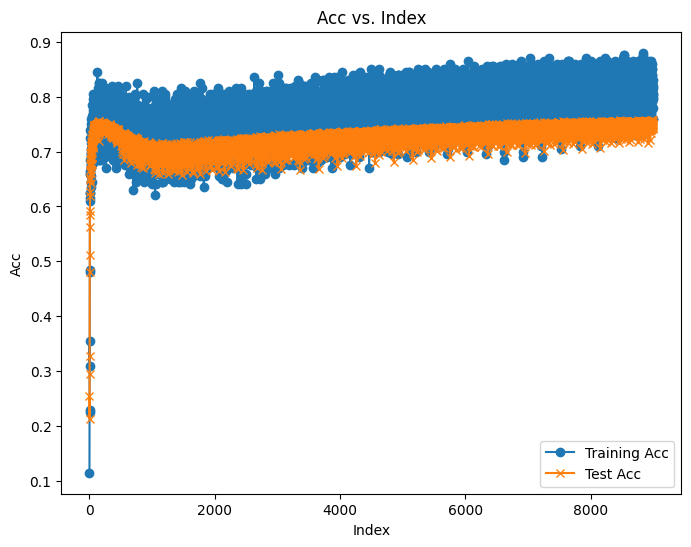

In [24]:
logs = model.train(**config)

In [25]:
model_zero = DNN(
    layers_config=[
        Layer(input_node=784, output_node=2048, activate="relu", zero=True),
        Layer(input_node=2048, output_node=512, activate="relu", zero=True),
        Layer(input_node=512, output_node=10, activate="softmax", zero=True),  # Assuming binary classification
    ],
    loss_func="crossentropy",
)

In [26]:
print(model_zero)

{'hidden_layers': {1: w: (2048, 784), b: (2048, 1), activate: relu,
                   2: w: (512, 2048), b: (512, 1), activate: relu,
                   3: w: (10, 512), b: (10, 1), activate: softmax},
 'input_dim': 784,
 'loss_func': 'crossentropy',
 'output_dim': 10}


In [27]:
config = base_train_conf | {"open_shuffle": False, "save_folder": "./fashion_zero_logs", "addition_check_data": {"x": x_test, "y": y_test}}

epoch 0: 100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


epoch 0: {'training_loss': np.float32(138155.08), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.848), 'test_acc': np.float64(0.1)}


epoch 1: 100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


epoch 1: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 2: 100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


epoch 2: {'training_loss': np.float32(138155.1), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.848), 'test_acc': np.float64(0.1)}


epoch 3: 100%|██████████| 300/300 [01:13<00:00,  4.09it/s]


epoch 3: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 4: 100%|██████████| 300/300 [01:12<00:00,  4.11it/s]


epoch 4: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.85), 'test_acc': np.float64(0.1)}


epoch 5: 100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


epoch 5: {'training_loss': np.float32(138155.12), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.85), 'test_acc': np.float64(0.1)}


epoch 6: 100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


epoch 6: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 7: 100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


epoch 7: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.854), 'test_acc': np.float64(0.1)}


epoch 8: 100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


epoch 8: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.854), 'test_acc': np.float64(0.1)}


epoch 9: 100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


epoch 9: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.85), 'test_acc': np.float64(0.1)}


epoch 10: 100%|██████████| 300/300 [01:12<00:00,  4.11it/s]


epoch 10: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.854), 'test_acc': np.float64(0.1)}


epoch 11: 100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


epoch 11: {'training_loss': np.float32(138155.1), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 12: 100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


epoch 12: {'training_loss': np.float32(138155.1), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.854), 'test_acc': np.float64(0.1)}


epoch 13: 100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


epoch 13: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 14: 100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


epoch 14: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 15: 100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


epoch 15: {'training_loss': np.float32(138155.1), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 16: 100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


epoch 16: {'training_loss': np.float32(138155.12), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 17: 100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


epoch 17: {'training_loss': np.float32(138155.14), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.854), 'test_acc': np.float64(0.1)}


epoch 18: 100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


epoch 18: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.854), 'test_acc': np.float64(0.1)}


epoch 19: 100%|██████████| 300/300 [01:13<00:00,  4.11it/s]


epoch 19: {'training_loss': np.float32(138155.12), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 20: 100%|██████████| 300/300 [01:12<00:00,  4.11it/s]


epoch 20: {'training_loss': np.float32(138155.1), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 21: 100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


epoch 21: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.854), 'test_acc': np.float64(0.1)}


epoch 22: 100%|██████████| 300/300 [01:13<00:00,  4.07it/s]


epoch 22: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.85), 'test_acc': np.float64(0.1)}


epoch 23: 100%|██████████| 300/300 [01:12<00:00,  4.11it/s]


epoch 23: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.855), 'test_acc': np.float64(0.1)}


epoch 24: 100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


epoch 24: {'training_loss': np.float32(138155.12), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 25: 100%|██████████| 300/300 [01:13<00:00,  4.11it/s]


epoch 25: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 26: 100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


epoch 26: {'training_loss': np.float32(138155.11), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}


epoch 27: 100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


epoch 27: {'training_loss': np.float32(138155.1), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.85), 'test_acc': np.float64(0.1)}


epoch 28: 100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


epoch 28: {'training_loss': np.float32(138155.1), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.854), 'test_acc': np.float64(0.1)}


epoch 29: 100%|██████████| 300/300 [01:13<00:00,  4.11it/s]


epoch 29: {'training_loss': np.float32(138155.08), 'training_acc': np.float64(0.1), 'test_loss': np.float32(23025.852), 'test_acc': np.float64(0.1)}
save to fashion_zero_logs


<Figure size 800x600 with 0 Axes>

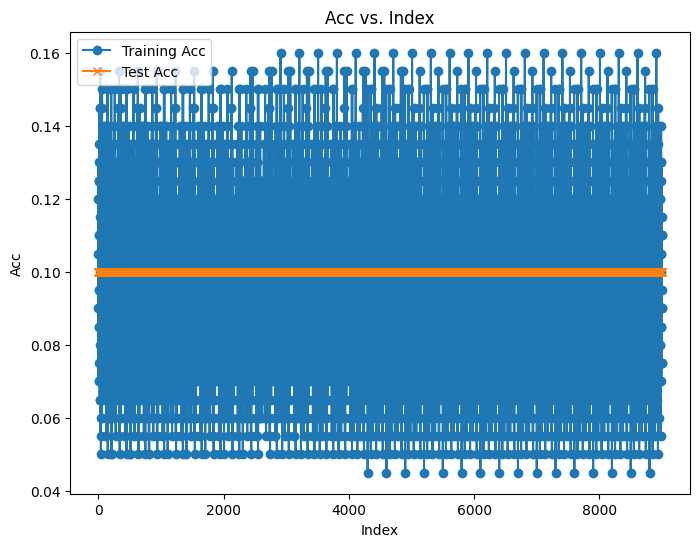

In [28]:
log_zero = model_zero.train(**config)

### 1.a


Normal Weights: Loss: 18290.5703125, Acc: 0.7567


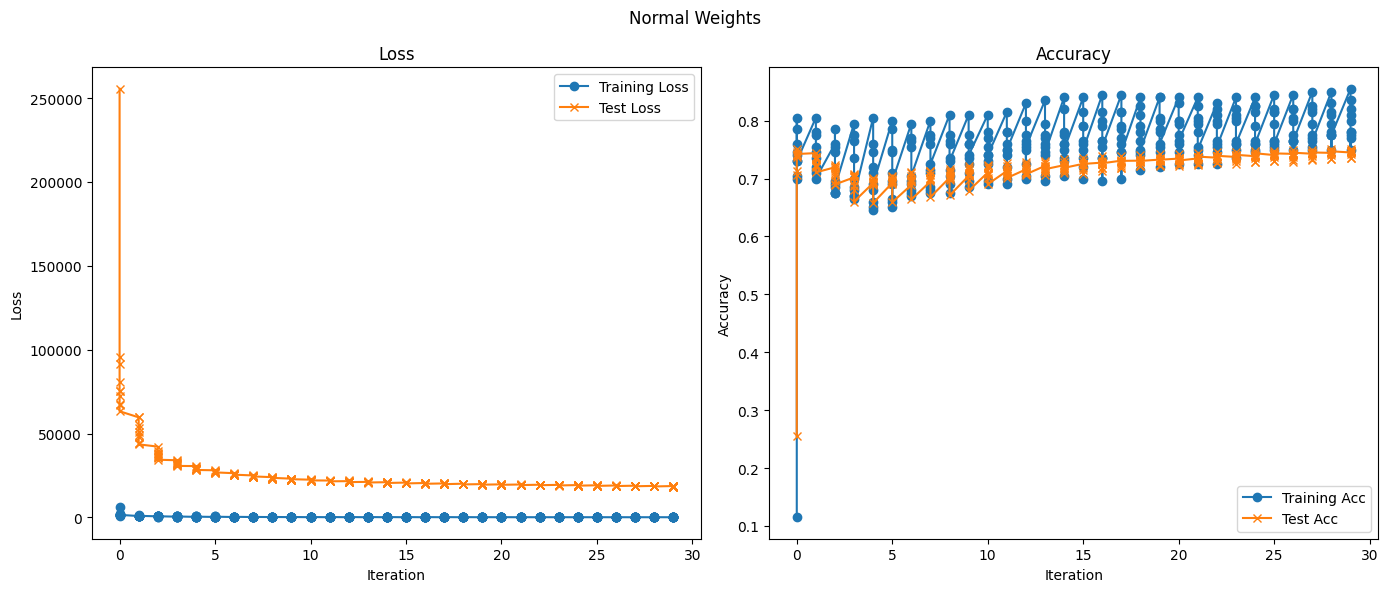

In [29]:
loss , acc = model.evaluate(x_test, y_test)
print(f"Normal Weights: Loss: {loss}, Acc: {acc}")
plot_graph_plt(logs.iloc[::30], "Normal Weights")

Zero Weights: Loss: 23025.8515625, Acc: 0.1


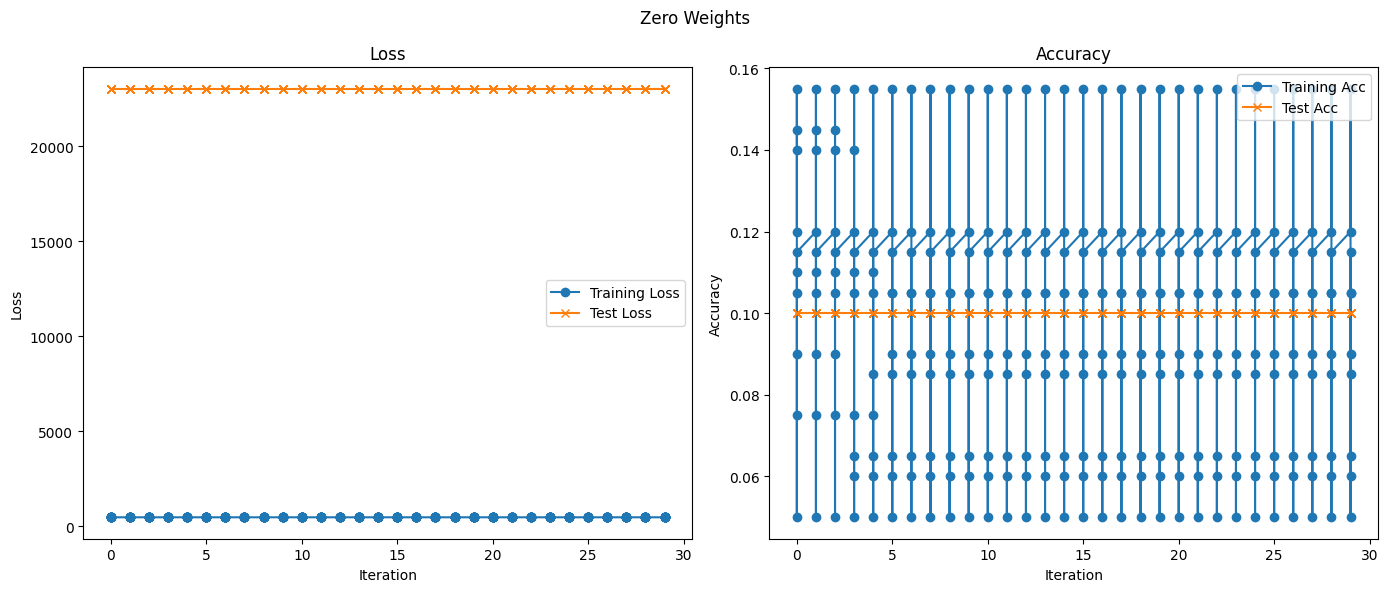

In [30]:
loss , acc = model_zero.evaluate(x_test, y_test)
print(f"Zero Weights: Loss: {loss}, Acc: {acc}")
plot_graph_plt(log_zero.iloc[::30], "Zero Weights")

### 1.b

Pre-trained weight is better than zero weight, here is the reason

**Zero Weights Initialization:**

- When all weights are initialized to zero, the gradients during backpropagation will be the same for all weights in each layer. This symmetry means that all weights will be updated equally, leading to no learning. This is why the accuracy remains very low (around 0.1).

**Pre-trained Weights:**

- Pre-trained weights provide a good starting point for the model. These weights have already been adjusted to capture useful features from the data, allowing the model to achieve better performance quickly. This is evident from the higher accuracy and lower loss in the learning curves.


## Question 2

In [39]:
model_dropout = Fnn.load_weights(
    './weights.npy',
    activation=[
        "relu",
        "relu",
        "softmax"
    ],
    dropout=[0.2, 0.2, 0.0],
    dtype=DTYPE
)

In [40]:
config = base_train_conf | {"open_shuffle": True, "save_folder": "./fashion_dropout_logs", "addition_check_data": {"x": x_test, "y": y_test}}

epoch 0: 100%|██████████| 300/300 [01:21<00:00,  3.69it/s]


epoch 0: {'training_loss': np.float32(355837.53), 'training_acc': np.float64(0.7506833333333334), 'test_loss': np.float32(61955.695), 'test_acc': np.float64(0.7442)}


epoch 1: 100%|██████████| 300/300 [01:20<00:00,  3.72it/s]


epoch 1: {'training_loss': np.float32(234163.48), 'training_acc': np.float64(0.7276), 'test_loss': np.float32(41158.195), 'test_acc': np.float64(0.7202)}


epoch 2: 100%|██████████| 300/300 [01:20<00:00,  3.71it/s]


epoch 2: {'training_loss': np.float32(242817.48), 'training_acc': np.float64(0.6104333333333334), 'test_loss': np.float32(42928.223), 'test_acc': np.float64(0.5982)}


epoch 3: 100%|██████████| 300/300 [01:20<00:00,  3.71it/s]


epoch 3: {'training_loss': np.float32(152349.16), 'training_acc': np.float64(0.6572666666666667), 'test_loss': np.float32(27488.44), 'test_acc': np.float64(0.6448)}


epoch 4: 100%|██████████| 300/300 [01:20<00:00,  3.71it/s]


epoch 4: {'training_loss': np.float32(127783.57), 'training_acc': np.float64(0.6228666666666667), 'test_loss': np.float32(22820.31), 'test_acc': np.float64(0.6062)}


epoch 5: 100%|██████████| 300/300 [01:21<00:00,  3.67it/s]


epoch 5: {'training_loss': np.float32(143563.73), 'training_acc': np.float64(0.6295166666666666), 'test_loss': np.float32(25312.492), 'test_acc': np.float64(0.622)}


epoch 6: 100%|██████████| 300/300 [01:21<00:00,  3.69it/s]


epoch 6: {'training_loss': np.float32(113666.86), 'training_acc': np.float64(0.62405), 'test_loss': np.float32(19860.256), 'test_acc': np.float64(0.6105)}


epoch 7: 100%|██████████| 300/300 [01:20<00:00,  3.72it/s]


epoch 7: {'training_loss': np.float32(104793.766), 'training_acc': np.float64(0.5984833333333334), 'test_loss': np.float32(18420.402), 'test_acc': np.float64(0.5882)}


epoch 8: 100%|██████████| 300/300 [01:21<00:00,  3.68it/s]


epoch 8: {'training_loss': np.float32(89455.56), 'training_acc': np.float64(0.6263), 'test_loss': np.float32(15778.699), 'test_acc': np.float64(0.6151)}


epoch 9: 100%|██████████| 300/300 [01:20<00:00,  3.72it/s]


epoch 9: {'training_loss': np.float32(96583.61), 'training_acc': np.float64(0.5985333333333334), 'test_loss': np.float32(16656.607), 'test_acc': np.float64(0.5873)}


epoch 10: 100%|██████████| 300/300 [01:21<00:00,  3.70it/s]


epoch 10: {'training_loss': np.float32(100387.695), 'training_acc': np.float64(0.5781166666666666), 'test_loss': np.float32(17453.986), 'test_acc': np.float64(0.5686)}


epoch 11: 100%|██████████| 300/300 [01:20<00:00,  3.73it/s]


epoch 11: {'training_loss': np.float32(98800.06), 'training_acc': np.float64(0.5826666666666667), 'test_loss': np.float32(16897.244), 'test_acc': np.float64(0.574)}


epoch 12: 100%|██████████| 300/300 [01:20<00:00,  3.70it/s]


epoch 12: {'training_loss': np.float32(80939.73), 'training_acc': np.float64(0.5716), 'test_loss': np.float32(13963.062), 'test_acc': np.float64(0.564)}


epoch 13: 100%|██████████| 300/300 [01:21<00:00,  3.70it/s]


epoch 13: {'training_loss': np.float32(80519.234), 'training_acc': np.float64(0.58285), 'test_loss': np.float32(13893.692), 'test_acc': np.float64(0.5707)}


epoch 14: 100%|██████████| 300/300 [01:20<00:00,  3.72it/s]


epoch 14: {'training_loss': np.float32(88822.414), 'training_acc': np.float64(0.5602333333333334), 'test_loss': np.float32(15419.704), 'test_acc': np.float64(0.5519)}


epoch 15: 100%|██████████| 300/300 [01:20<00:00,  3.71it/s]


epoch 15: {'training_loss': np.float32(83626.91), 'training_acc': np.float64(0.5376833333333333), 'test_loss': np.float32(14309.833), 'test_acc': np.float64(0.5289)}


epoch 16: 100%|██████████| 300/300 [01:20<00:00,  3.73it/s]


epoch 16: {'training_loss': np.float32(78726.23), 'training_acc': np.float64(0.5621166666666667), 'test_loss': np.float32(13375.924), 'test_acc': np.float64(0.5551)}


epoch 17: 100%|██████████| 300/300 [01:20<00:00,  3.71it/s]


epoch 17: {'training_loss': np.float32(80586.98), 'training_acc': np.float64(0.5138333333333334), 'test_loss': np.float32(13687.064), 'test_acc': np.float64(0.5084)}


epoch 18: 100%|██████████| 300/300 [01:20<00:00,  3.72it/s]


epoch 18: {'training_loss': np.float32(124081.164), 'training_acc': np.float64(0.53865), 'test_loss': np.float32(21063.023), 'test_acc': np.float64(0.5298)}


epoch 19: 100%|██████████| 300/300 [01:20<00:00,  3.72it/s]


epoch 19: {'training_loss': np.float32(77840.72), 'training_acc': np.float64(0.5505166666666667), 'test_loss': np.float32(13219.696), 'test_acc': np.float64(0.5403)}


epoch 20: 100%|██████████| 300/300 [01:21<00:00,  3.70it/s]


epoch 20: {'training_loss': np.float32(76436.36), 'training_acc': np.float64(0.5688333333333333), 'test_loss': np.float32(13111.668), 'test_acc': np.float64(0.56)}


epoch 21: 100%|██████████| 300/300 [01:20<00:00,  3.72it/s]


epoch 21: {'training_loss': np.float32(80055.016), 'training_acc': np.float64(0.55545), 'test_loss': np.float32(13710.675), 'test_acc': np.float64(0.5469)}


epoch 22: 100%|██████████| 300/300 [01:21<00:00,  3.69it/s]


epoch 22: {'training_loss': np.float32(79602.68), 'training_acc': np.float64(0.5360333333333334), 'test_loss': np.float32(13556.045), 'test_acc': np.float64(0.5264)}


epoch 23: 100%|██████████| 300/300 [01:20<00:00,  3.71it/s]


epoch 23: {'training_loss': np.float32(95575.555), 'training_acc': np.float64(0.5349), 'test_loss': np.float32(16276.98), 'test_acc': np.float64(0.5265)}


epoch 24: 100%|██████████| 300/300 [01:21<00:00,  3.70it/s]


epoch 24: {'training_loss': np.float32(80195.2), 'training_acc': np.float64(0.5589166666666666), 'test_loss': np.float32(13779.919), 'test_acc': np.float64(0.55)}


epoch 25: 100%|██████████| 300/300 [01:20<00:00,  3.71it/s]


epoch 25: {'training_loss': np.float32(82784.414), 'training_acc': np.float64(0.5532666666666667), 'test_loss': np.float32(14235.194), 'test_acc': np.float64(0.542)}


epoch 26: 100%|██████████| 300/300 [01:21<00:00,  3.69it/s]


epoch 26: {'training_loss': np.float32(78826.86), 'training_acc': np.float64(0.52475), 'test_loss': np.float32(13367.055), 'test_acc': np.float64(0.5149)}


epoch 27: 100%|██████████| 300/300 [01:21<00:00,  3.67it/s]


epoch 27: {'training_loss': np.float32(78100.93), 'training_acc': np.float64(0.5310333333333334), 'test_loss': np.float32(13427.997), 'test_acc': np.float64(0.5229)}


epoch 28: 100%|██████████| 300/300 [01:21<00:00,  3.68it/s]


epoch 28: {'training_loss': np.float32(73159.66), 'training_acc': np.float64(0.5642333333333334), 'test_loss': np.float32(12610.293), 'test_acc': np.float64(0.5565)}


epoch 29: 100%|██████████| 300/300 [01:21<00:00,  3.69it/s]


epoch 29: {'training_loss': np.float32(72653.02), 'training_acc': np.float64(0.55965), 'test_loss': np.float32(12428.656), 'test_acc': np.float64(0.5492)}
save to fashion_dropout_logs


<Figure size 800x600 with 0 Axes>

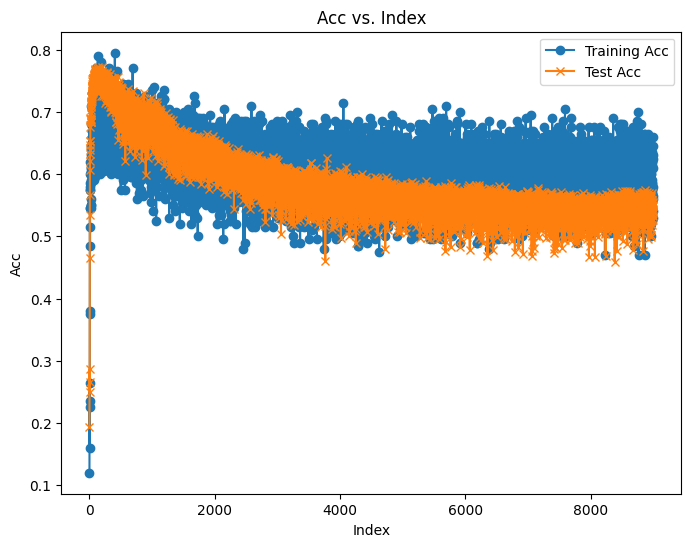

In [41]:
log_model_dropout = model_dropout.train(**config)

### 2.a


Dropout Weights: Loss: 12428.65625, Acc: 0.5492


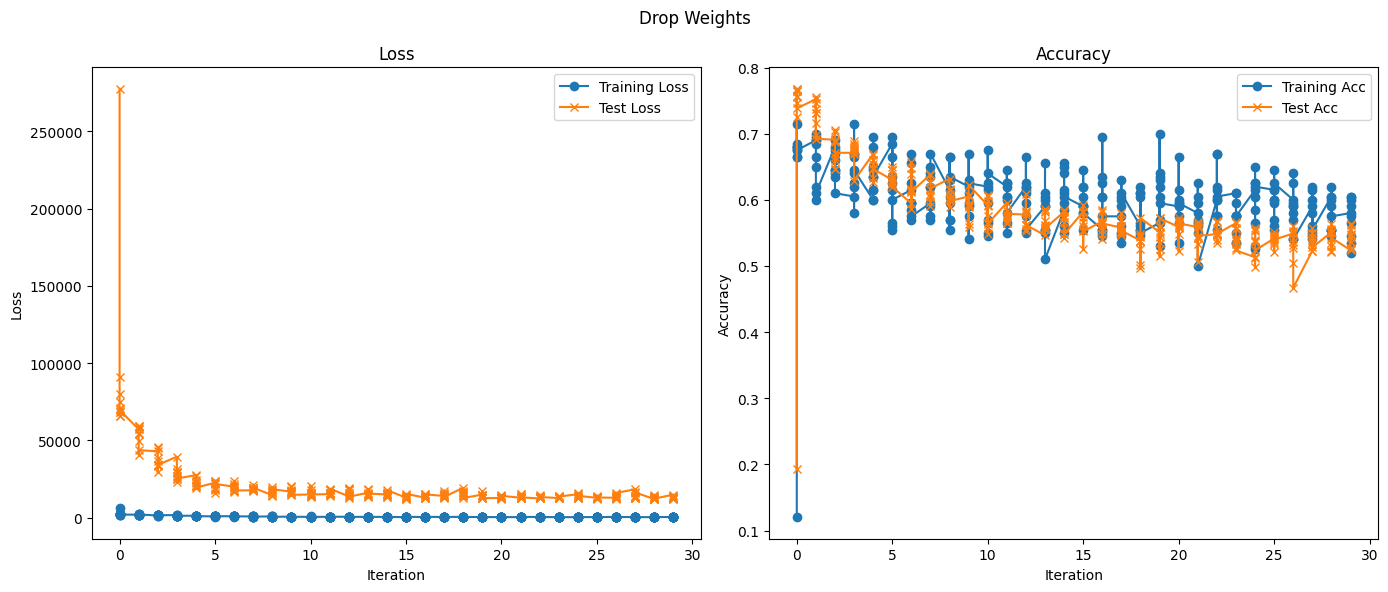

In [42]:
loss , acc = model_dropout.evaluate(x_test, y_test)
print(f"Dropout Weights: Loss: {loss}, Acc: {acc}")
plot_graph_plt(log_model_dropout.iloc[::30], "Drop Weights")

### 2.b
**Effect of Dropout Layers on Model Performance:**

1. **Regularization**:
   - Dropout acts as a regularization technique that helps prevent overfitting. By randomly dropping units during training, the model is forced to learn more robust features that generalize better to unseen data. In the "Drop Weights" graph, we can see that the training loss is slightly higher and more stable compared to the "Normal Weights" graph, indicating that the model is not overfitting to the training data.

2. **Model Robustness**:
   - Dropout makes the network less sensitive to specific weights, leading to a more robust model. This is because the model cannot rely on any single neuron and must distribute the learning across many neurons. This can lead to better generalization and improved test accuracy. In the "Drop Weights" graph, the test accuracy is more stable and does not fluctuate as much as in the "Normal Weights" graph.

3. **Training Dynamics**:
   - The introduction of dropout can slow down the training process because the model has to adapt to the random dropping of neurons. However, this can lead to a more stable training process and prevent the model from quickly converging to a suboptimal solution. The "Drop Weights" graph shows a more gradual improvement in accuracy, indicating a more stable training process.

**Discussion:**

In the provided learning curves, the model with dropout (Drop Weights) shows a more stable training process with less overfitting compared to the model without dropout (Normal Weights). The test accuracy is also more stable, indicating better generalization. The initial spike in test loss and accuracy is due to the model adjusting to the dropout mechanism, but it stabilizes over time.

## Question 3

In [35]:
model_random= Fnn.load_weights(
    './weights.npy',
    activation=[
        "relu",
        "relu",
        "softmax"
    ],
    dtype=DTYPE
)

In [36]:
config = base_train_conf | {"open_shuffle": True, "save_folder": "./fashion_random_batkich_logs", "addition_check_data": {"x": x_test, "y": y_test}}

epoch 0: 100%|██████████| 300/300 [01:18<00:00,  3.82it/s]


epoch 0: {'training_loss': np.float32(295394.12), 'training_acc': np.float64(0.7311833333333333), 'test_loss': np.float32(53367.363), 'test_acc': np.float64(0.7152)}


epoch 1: 100%|██████████| 300/300 [01:16<00:00,  3.92it/s]


epoch 1: {'training_loss': np.float32(188463.6), 'training_acc': np.float64(0.7214833333333334), 'test_loss': np.float32(36007.977), 'test_acc': np.float64(0.7056)}


epoch 2: 100%|██████████| 300/300 [01:17<00:00,  3.90it/s]


epoch 2: {'training_loss': np.float32(152581.1), 'training_acc': np.float64(0.7114), 'test_loss': np.float32(30562.697), 'test_acc': np.float64(0.691)}


epoch 3: 100%|██████████| 300/300 [01:16<00:00,  3.91it/s]


epoch 3: {'training_loss': np.float32(127898.45), 'training_acc': np.float64(0.7105), 'test_loss': np.float32(27445.258), 'test_acc': np.float64(0.6841)}


epoch 4: 100%|██████████| 300/300 [01:17<00:00,  3.89it/s]


epoch 4: {'training_loss': np.float32(111719.22), 'training_acc': np.float64(0.7183), 'test_loss': np.float32(25024.502), 'test_acc': np.float64(0.6889)}


epoch 5: 100%|██████████| 300/300 [01:16<00:00,  3.90it/s]


epoch 5: {'training_loss': np.float32(101663.21), 'training_acc': np.float64(0.7215333333333334), 'test_loss': np.float32(23260.875), 'test_acc': np.float64(0.6915)}


epoch 6: 100%|██████████| 300/300 [01:17<00:00,  3.86it/s]


epoch 6: {'training_loss': np.float32(93945.9), 'training_acc': np.float64(0.7247166666666667), 'test_loss': np.float32(22034.7), 'test_acc': np.float64(0.6926)}


epoch 7: 100%|██████████| 300/300 [01:17<00:00,  3.89it/s]


epoch 7: {'training_loss': np.float32(85864.375), 'training_acc': np.float64(0.7147833333333333), 'test_loss': np.float32(21319.717), 'test_acc': np.float64(0.6801)}


epoch 8: 100%|██████████| 300/300 [01:16<00:00,  3.91it/s]


epoch 8: {'training_loss': np.float32(79021.42), 'training_acc': np.float64(0.7352333333333333), 'test_loss': np.float32(20533.246), 'test_acc': np.float64(0.699)}


epoch 9: 100%|██████████| 300/300 [01:16<00:00,  3.92it/s]


epoch 9: {'training_loss': np.float32(76062.63), 'training_acc': np.float64(0.7050333333333333), 'test_loss': np.float32(20056.057), 'test_acc': np.float64(0.6696)}


epoch 10: 100%|██████████| 300/300 [01:16<00:00,  3.91it/s]


epoch 10: {'training_loss': np.float32(71527.266), 'training_acc': np.float64(0.7325166666666667), 'test_loss': np.float32(19446.086), 'test_acc': np.float64(0.6911)}


epoch 11: 100%|██████████| 300/300 [01:16<00:00,  3.90it/s]


epoch 11: {'training_loss': np.float32(68634.83), 'training_acc': np.float64(0.7490333333333333), 'test_loss': np.float32(19302.68), 'test_acc': np.float64(0.709)}


epoch 12: 100%|██████████| 300/300 [01:16<00:00,  3.91it/s]


epoch 12: {'training_loss': np.float32(66040.91), 'training_acc': np.float64(0.7359666666666667), 'test_loss': np.float32(18995.818), 'test_acc': np.float64(0.6961)}


epoch 13: 100%|██████████| 300/300 [01:16<00:00,  3.91it/s]


epoch 13: {'training_loss': np.float32(60237.82), 'training_acc': np.float64(0.7641666666666667), 'test_loss': np.float32(18168.68), 'test_acc': np.float64(0.7189)}


epoch 14: 100%|██████████| 300/300 [01:16<00:00,  3.92it/s]


epoch 14: {'training_loss': np.float32(58231.457), 'training_acc': np.float64(0.7666666666666667), 'test_loss': np.float32(17875.96), 'test_acc': np.float64(0.7232)}


epoch 15: 100%|██████████| 300/300 [01:17<00:00,  3.90it/s]


epoch 15: {'training_loss': np.float32(57028.035), 'training_acc': np.float64(0.76335), 'test_loss': np.float32(17821.525), 'test_acc': np.float64(0.7201)}


epoch 16: 100%|██████████| 300/300 [01:16<00:00,  3.90it/s]


epoch 16: {'training_loss': np.float32(53283.637), 'training_acc': np.float64(0.77065), 'test_loss': np.float32(17325.553), 'test_acc': np.float64(0.7231)}


epoch 17: 100%|██████████| 300/300 [01:16<00:00,  3.92it/s]


epoch 17: {'training_loss': np.float32(52841.48), 'training_acc': np.float64(0.7769), 'test_loss': np.float32(17231.541), 'test_acc': np.float64(0.7286)}


epoch 18: 100%|██████████| 300/300 [01:16<00:00,  3.93it/s]


epoch 18: {'training_loss': np.float32(51033.496), 'training_acc': np.float64(0.7787333333333334), 'test_loss': np.float32(17153.28), 'test_acc': np.float64(0.7296)}


epoch 19: 100%|██████████| 300/300 [01:16<00:00,  3.92it/s]


epoch 19: {'training_loss': np.float32(55492.81), 'training_acc': np.float64(0.7357333333333334), 'test_loss': np.float32(17987.95), 'test_acc': np.float64(0.6885)}


epoch 20: 100%|██████████| 300/300 [01:16<00:00,  3.91it/s]


epoch 20: {'training_loss': np.float32(50252.426), 'training_acc': np.float64(0.7761666666666667), 'test_loss': np.float32(17221.781), 'test_acc': np.float64(0.7241)}


epoch 21: 100%|██████████| 300/300 [01:16<00:00,  3.91it/s]


epoch 21: {'training_loss': np.float32(46387.08), 'training_acc': np.float64(0.7849), 'test_loss': np.float32(16612.555), 'test_acc': np.float64(0.7379)}


epoch 22: 100%|██████████| 300/300 [01:16<00:00,  3.90it/s]


epoch 22: {'training_loss': np.float32(45117.48), 'training_acc': np.float64(0.7855666666666666), 'test_loss': np.float32(16484.115), 'test_acc': np.float64(0.7339)}


epoch 23: 100%|██████████| 300/300 [01:16<00:00,  3.91it/s]


epoch 23: {'training_loss': np.float32(45433.03), 'training_acc': np.float64(0.7759833333333334), 'test_loss': np.float32(16435.357), 'test_acc': np.float64(0.7229)}


epoch 24: 100%|██████████| 300/300 [01:16<00:00,  3.91it/s]


epoch 24: {'training_loss': np.float32(43909.543), 'training_acc': np.float64(0.78775), 'test_loss': np.float32(16364.854), 'test_acc': np.float64(0.7344)}


epoch 25: 100%|██████████| 300/300 [01:17<00:00,  3.90it/s]


epoch 25: {'training_loss': np.float32(42074.24), 'training_acc': np.float64(0.79095), 'test_loss': np.float32(16134.038), 'test_acc': np.float64(0.7376)}


epoch 26: 100%|██████████| 300/300 [01:16<00:00,  3.91it/s]


epoch 26: {'training_loss': np.float32(41381.664), 'training_acc': np.float64(0.7916333333333333), 'test_loss': np.float32(16112.995), 'test_acc': np.float64(0.7382)}


epoch 27: 100%|██████████| 300/300 [01:16<00:00,  3.93it/s]


epoch 27: {'training_loss': np.float32(41040.8), 'training_acc': np.float64(0.7931), 'test_loss': np.float32(16108.165), 'test_acc': np.float64(0.7416)}


epoch 28: 100%|██████████| 300/300 [01:16<00:00,  3.92it/s]


epoch 28: {'training_loss': np.float32(40671.31), 'training_acc': np.float64(0.79445), 'test_loss': np.float32(16081.447), 'test_acc': np.float64(0.7415)}


epoch 29: 100%|██████████| 300/300 [01:16<00:00,  3.90it/s]


epoch 29: {'training_loss': np.float32(42535.258), 'training_acc': np.float64(0.7750666666666667), 'test_loss': np.float32(16430.492), 'test_acc': np.float64(0.7235)}
save to fashion_random_batkich_logs


<Figure size 800x600 with 0 Axes>

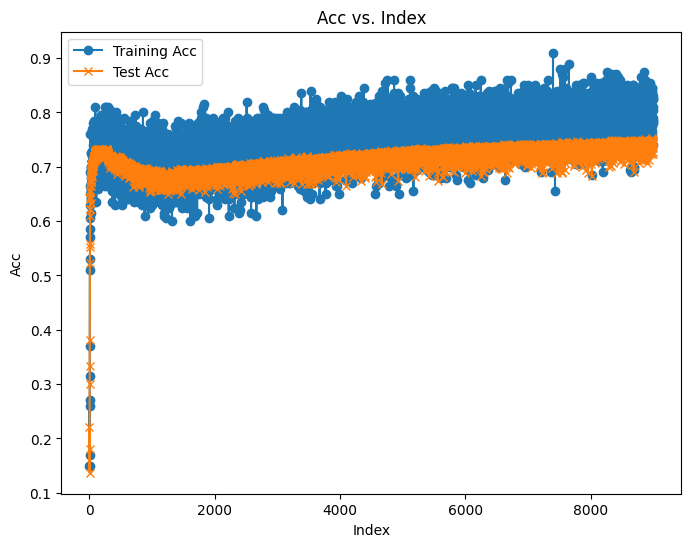

In [37]:
log_model_random = model_random.train(**config)

### 3.a

Random Batch Weights: Loss: 16430.4921875, Acc: 0.7235


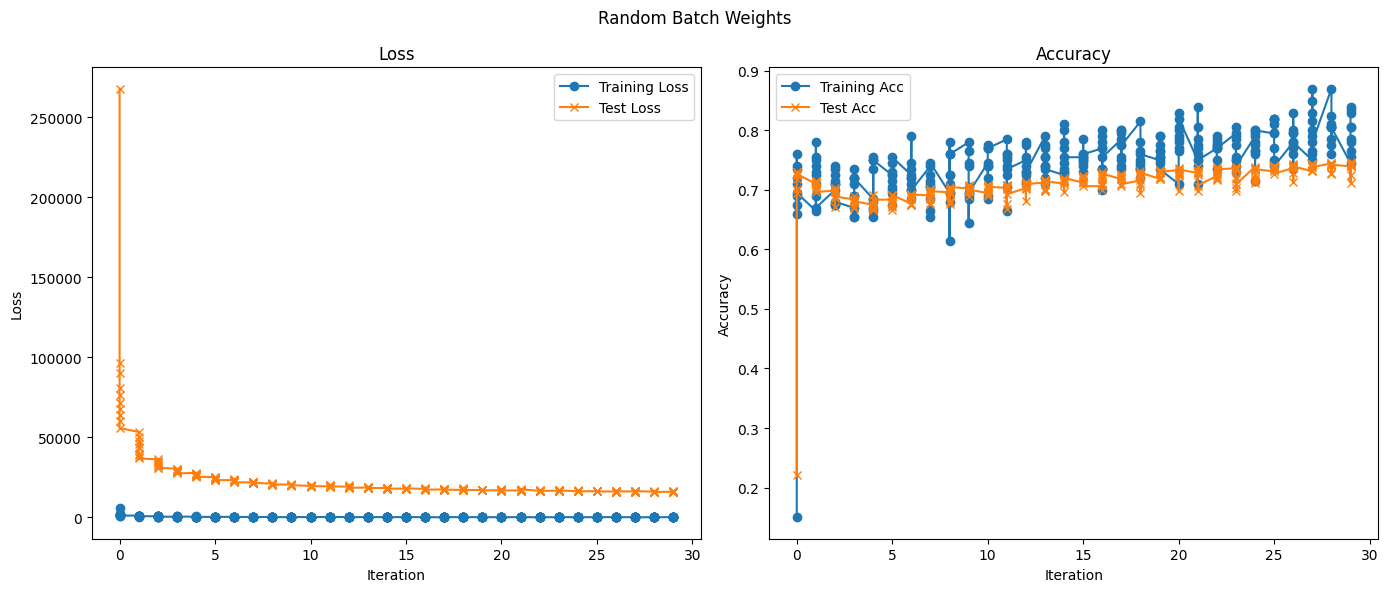

In [38]:
loss , acc = model_random.evaluate(x_test, y_test)
print(f"Random Batch Weights: Loss: {loss}, Acc: {acc}")
plot_graph_plt(log_model_random.iloc[::30], "Random Batch Weights")

### 3.b
**Effect of Reshuffling Images on Model Performance:**

1. **Improved Generalization**:
   - Reshuffling the training data at the beginning of each epoch helps the model to generalize better. By presenting the data in a different order each time, the model is less likely to memorize the order of the training samples and more likely to learn the underlying patterns. This can be observed in the "Random Batch Weights" graph where the test accuracy is more stable and gradually improves over time.

2. **Reduced Overfitting**:
   - Reshuffling helps to reduce overfitting by ensuring that the model does not see the same sequence of data in every epoch. This prevents the model from becoming too dependent on the specific order of the training data. In the "Normal Weights" graph, the training accuracy is higher than the test accuracy, indicating some level of overfitting. In contrast, the "Random Batch Weights" graph shows a more balanced performance between training and test accuracy.

3. **Better Convergence**:
   - Reshuffling can lead to better convergence during training. By varying the order of the training samples, the model can escape local minima and find a better solution. This is evident in the "Random Batch Weights" graph where the training loss decreases more smoothly compared to the "Normal Weights" graph.

**Discussion:**

In the provided learning curves, the model with reshuffled data (Random Batch Weights) shows a more stable and gradual improvement in both training and test accuracy compared to the model without reshuffling (Normal Weights). The reshuffling process helps the model to generalize better, reduce overfitting, and achieve better convergence.

## Part 2

In [2]:
import lightning as L
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
from pathlib import Path
from natsort import natsorted
import numpy as np
from PIL import Image
import pandas as pd

import albumentations as A
from albumentations.pytorch import ToTensorV2
from lightning.pytorch.loggers import  CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('high')

In [3]:
DATASET_PATH = Path("./flower")
assert DATASET_PATH.exists()

In [4]:
def load_labels(path: Path) -> dict:
    with open(path, "r") as f:
        label_map =  json.load(f)
        
    return dict(sorted(label_map.items(), key=lambda x: int(x[0])))

### Load label map

In [5]:
label_map = load_labels(DATASET_PATH / "cat_to_name.json")

In [6]:
class FlowerTestDataset(Dataset):
    def __init__(self, path:str | Path, transform: transforms.Compose | A.Compose=None):
        if isinstance(path, str):
            path = Path(path)
        
        self.dataset = natsorted((DATASET_PATH / "test").iterdir())
        self.transform = transform 
        
        # default transform
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            return 
        
        # specify the transform
        if isinstance(transform, A.Compose):
            self.transform = lambda x: transform(image=np.array(x))["image"]
            
        return 

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path = self.dataset[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        
        return img 

In [7]:
class FlowerDataModule(L.LightningDataModule):
    def __init__(
        self, 
        dataset_path: Path | str, 
        batch_size: int = 32, 
        train_val_ration: float = 0.8, 
        transform:dict[str, transforms.Compose]| None = None,
        worker: int = 4,
    )->None:
        super().__init__()
        
        # dataset path
        self.dataset_path = dataset_path if isinstance(dataset_path, Path) else Path(dataset_path)
        self.batch_size = batch_size
        self.worker = worker
        
        # dataset
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.train_split_ratio = train_val_ration   
        # about the mapping and class 
        self.label_map = None
        self.num_classes = None
        
        # transforms
        self.transforms = transform
        
        if self.transforms is None:
            self.transforms = {
                "train": transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]),
                "val": transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]),
                "test": transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])
            }
        
        self.prepare_data()
        return

    def prepare_data(self):
        self.label_map = self.load_label_map()
        self.num_classes = len(self.label_map)
        return
    
    def load_label_map(self)->dict:
        json_file = self.dataset_path / "cat_to_name.json"
        with open(json_file) as f:
            label_map = json.load(f)
            
        label_map = dict(sorted(label_map.items(), key=lambda x: int(x[0])))
        return label_map
    
    def setup(self, stage:str = None):
        if stage == "fit" or stage is None:
            self.train_dataset, self.val_dataset = self.load_dataset(self.train_split_ratio)
            
        if  stage in ["test", "predict"] or stage is None:
            self.test_dataset = self.load_dataset(train_split_ratio=None ,test_data=True)

        return
    
    def _A_transform_wrapper(self, transform: A.Compose):
        return lambda x: transform(image=np.array(x))["image"]
    
    def load_dataset(self, train_split_ratio: float | None = 0.8, test_data: bool = False):
        if test_data and train_split_ratio is None:
            return FlowerTestDataset(self.dataset_path / "test", self.transforms["test"])
            
        full_dataset_path = self.dataset_path / "train"
        full_dataset = ImageFolder(full_dataset_path)
        
        # random split the dataset
        train_size = int(train_split_ratio * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_set, val_set = random_split(full_dataset, [train_size, val_size])
        
        # config the transform
        train_set.dataset.transform = self.transforms["train"] if isinstance(self.transforms["train"], transforms.Compose) else self._A_transform_wrapper(self.transforms["train"])
        val_set.dataset.transform = self.transforms["val"] if isinstance(self.transforms["val"], transforms.Compose) else self._A_transform_wrapper(self.transforms["val"])
        
        return train_set, val_set

    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.worker,
            shuffle=True,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.worker,
            pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.worker
        )

    def predict_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.worker
        )
    # def __repr__(self):
    #     return f"FlowerDataModule(dataset_path={self.dataset_path}, batch_size={self.batch_size})"

In [8]:
def plot_graph_plt_nn(logs: pd.DataFrame, title: str):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Loss on the first subplot
    axs[0].plot(logs.index, logs["train_loss"],  label="Training Loss")
    axs[0].plot(logs.index, logs["val_loss"],  label="Val Loss")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss")
    axs[0].legend()
    
    # Plot Accuracy on the second subplot
    axs[1].plot(logs.index, logs["train_acc"],  label="Training Acc")
    axs[1].plot(logs.index, logs["val_acc"],  label="Val Acc")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [9]:
CLASS = 102
BATCH_SIZE = 160
EPOCHS = 20
WORKER = 4

In [10]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=0.0625, scale=(0.9, 1.1), rotate=(-30, 30), p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


# def transforms_wrapper

## Question 1

In [ ]:
class SimpleCNN(L.LightningModule):
    def __init__(self, num_classes: int = 10):
        super(SimpleCNN, self).__init__()
        # First conv layer: input channels (3 for RGB) to 16 channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        # Second conv layer: 16 channels to 32 channels
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Compute the size after two pool layers for an input image of size 224x224:
        # 224/2 -> 112, 112/2 -> 56, with 32 channels
        self.fc = nn.Linear(32 * 56 * 56, num_classes)
        
        self.save_hyperparameters()
        return 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        self.log_dict({"train_loss": loss, "train_acc": acc})
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        self.log_dict({"val_loss": loss, "val_acc": acc})
        return 
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)
        
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    

In [10]:
model = SimpleCNN(num_classes=CLASS)

In [12]:
datamodule = FlowerDataModule(
    dataset_path=DATASET_PATH,
    batch_size=BATCH_SIZE,
    train_val_ration=0.9,
    transform={
        "train": train_transform,
        "val": val_transform,
        "test": test_transform
    },
    worker=WORKER
)

In [13]:
csv_logger = CSVLogger("logs_flower", name="flower_batch_norm")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    # dirpath="checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
    save_last=True,
)

# %%
trainer = L.Trainer(
    callbacks=[checkpoint_callback],
    logger=csv_logger,
    max_epochs=EPOCHS,
    # fast_dev_run=True,
    log_every_n_steps=10,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | conv1 | Conv2d      | 448    | train
1 | bn1   | BatchNorm2d | 32     | train
2 | conv2 | Conv2d      | 4.6 K  | train
3 | bn2   | BatchNorm2d | 64     | train
4 | pool  | MaxPool2d   | 0      | train
5 | fc    | Linear      | 10.2 M | train
----------------------------------------------
10.2 M    Trainable params
0         Non-trainable params
10.2 M    Total params
40.965    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 33/33 [00:06<00:00,  5.17it/s, v_num=1]         

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 33/33 [00:06<00:00,  4.85it/s, v_num=1]


In [38]:
training_log = pd.read_csv("logs_flower/flower_batch_norm/version_0/metrics.csv")
training_log = training_log.ffill().fillna(0)

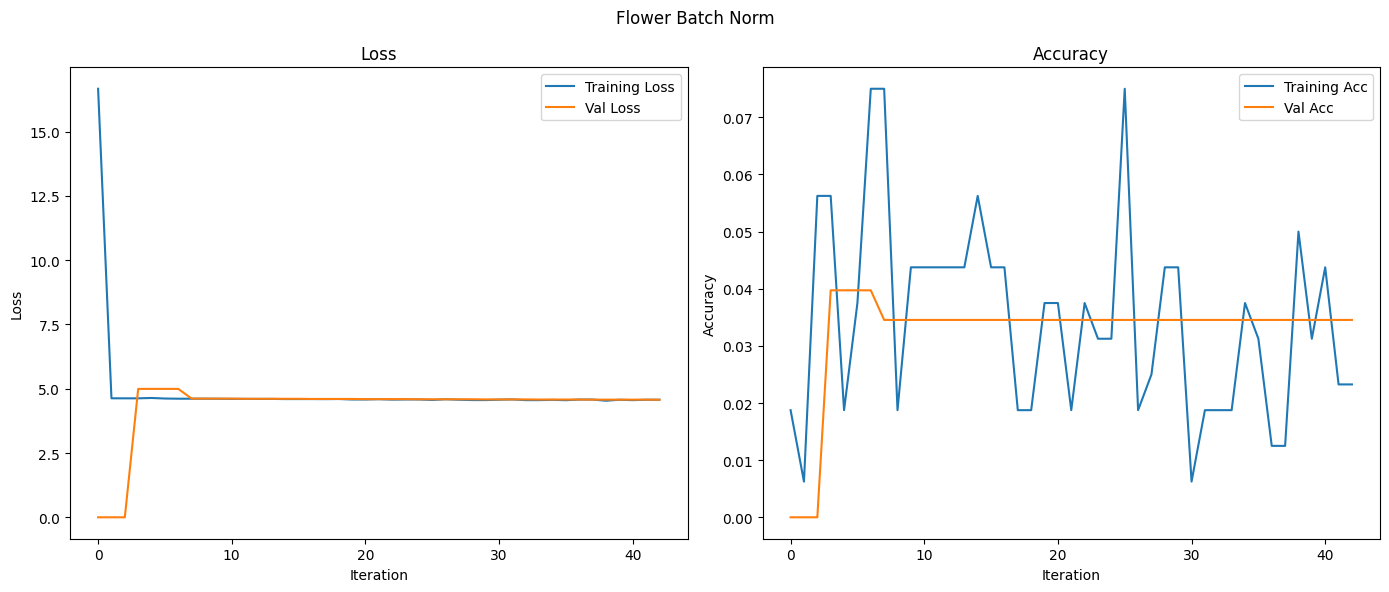

In [39]:
plot_graph_plt_nn(training_log, "Flower Batch Norm")

## Question 2


In [43]:
class LayerNormCNN(L.LightningModule):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        # First conv layer: input channels (3 for RGB) to 16 channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Use LayerNorm with the expected shape after conv1 (input image is 224x224)
        self.ln1 = nn.LayerNorm([16, 224, 224])
        # Second conv layer: 16 channels to 32 channels
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # After first pooling, the spatial size becomes 112x112
        self.ln2 = nn.LayerNorm([32, 112, 112])
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # After second pooling, spatial size becomes 56x56
        self.fc = nn.Linear(32 * 56 * 56, num_classes)
        
        self.save_hyperparameters()
        return 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        self.log_dict({"train_loss": loss, "train_acc": acc})
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        self.log_dict({"val_loss": loss, "val_acc": acc})
        return 
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)
        
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    

In [44]:
model = LayerNormCNN(num_classes=CLASS)

In [ ]:
## same setup of datamodule

In [45]:
csv_logger = CSVLogger("logs_flower", name="flower_layer_norm")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    # dirpath="checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
    save_last=True,
)

# %%
trainer = L.Trainer(
    callbacks=[checkpoint_callback],
    logger=csv_logger,
    max_epochs=EPOCHS,
    # fast_dev_run=True,
    log_every_n_steps=10,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [46]:
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 448    | train
1 | ln1   | LayerNorm | 1.6 M  | train
2 | conv2 | Conv2d    | 4.6 K  | train
3 | ln2   | LayerNorm | 802 K  | train
4 | pool  | MaxPool2d | 0      | train
5 | fc    | Linear    | 10.2 M | train
--------------------------------------------
12.6 M    Trainable params
0         Non-trainable params
12.6 M    Total params
50.598    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 33/33 [00:06<00:00,  5.11it/s, v_num=0]         

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 33/33 [00:06<00:00,  4.91it/s, v_num=0]


In [47]:
training_log = pd.read_csv("./logs_flower/flower_layer_norm/version_0/metrics.csv")
training_log = training_log.ffill().fillna(0)

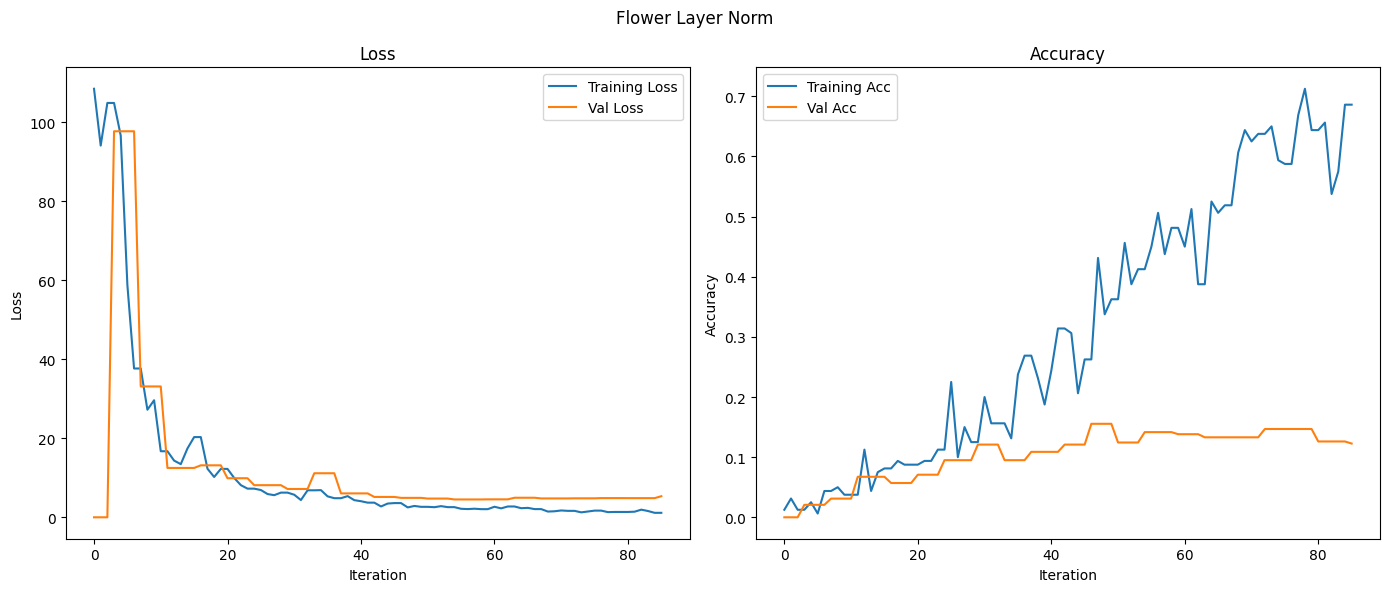

In [48]:
plot_graph_plt_nn(training_log, "Flower Layer Norm")

**Comparison and Discussion of Batch Normalization and Layer Normalization:**

1. **Training Loss and Accuracy**:
   - **Batch Normalization**: The training loss decreases rapidly at the beginning and then stabilizes at a lower value. However, the training accuracy fluctuates significantly and does not show a clear upward trend. This indicates that the model might be struggling to learn effectively.
   - **Layer Normalization**: The training loss decreases more gradually but consistently over time. The training accuracy shows a clear upward trend, indicating that the model is learning more effectively and steadily improving.

2. **Validation Loss and Accuracy**:
   - **Batch Normalization**: The validation loss remains relatively high and does not show significant improvement over time. The validation accuracy is very low and does not improve, indicating poor generalization to the validation set.
   - **Layer Normalization**: The validation loss decreases significantly and stabilizes at a lower value. The validation accuracy shows a gradual improvement, indicating better generalization to the validation set.

3. **Stability and Convergence**:
   - **Batch Normalization**: The training process appears to be less stable, with significant fluctuations in training accuracy. This instability might be due to the batch-wise normalization, which can introduce noise and variability in the gradient updates.
   - **Layer Normalization**: The training process is more stable, with a smoother decrease in training loss and a more consistent increase in training accuracy. Layer normalization normalizes across the features of each individual sample, which can lead to more stable gradient updates and better convergence.

**Discussion**:
- **Batch Normalization** is effective in many scenarios, especially when the batch size is large. However, it can introduce instability when the batch size is small or when the data distribution varies significantly between batches.
- **Layer Normalization** provides more stable training and better generalization in this case. It normalizes across the features of each sample, making it less sensitive to batch size and more robust to variations in data distribution.

In summary, for this specific task, layer normalization appears to provide better performance and stability compared to batch normalization.



## Question 3

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([channels, 56, 56])
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([channels, 56, 56])

    def forward(self, x):
        identity = x
       
        out = F.relu(self.ln1(self.conv1(x)))
        out = self.ln2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out


In [12]:
class SimpleResNet(L.LightningModule):
    
    def __init__(self, num_blocks: int = 3, num_classes: int = 10, block_class=ResidualBlock):
        super().__init__()
        # Initial convolution: input 3 channels -> 64 channels.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)  # (64, 112, 112)
        self.ln1 = nn.LayerNorm([64, 112, 112])
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)         # (64, 56, 56)
        # Stack n residual blocks.
        self.blocks = nn.Sequential(*[block_class(64) for _ in range(num_blocks)])
        # Global average pooling to collapse spatial dims.
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)
        self.save_hyperparameters()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.blocks(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        self.log_dict({"train_loss": loss, "train_acc": acc})
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        self.log_dict({"val_loss": loss, "val_acc": acc})
        return 
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)
        
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    

In [13]:
SIMPLE_RES_BATCH_SIZE = 64
SIMPLE_RES_EPOCHS = 50
SIMPLE_RES_WORKER = 2


In [14]:
model = SimpleResNet(num_blocks=18, num_classes=CLASS)

In [15]:
datamodule = FlowerDataModule(
    dataset_path=DATASET_PATH,
    batch_size=SIMPLE_RES_BATCH_SIZE,
    train_val_ration=0.9,
    transform={
        "train": train_transform,
        "val": val_transform,
        "test": test_transform
    },
    worker=SIMPLE_RES_WORKER
)

In [16]:
csv_logger = CSVLogger("logs_flower", name="flower_Simple_ResNet")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    # dirpath="checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
    save_last=True,
)

# %%
trainer = L.Trainer(
    callbacks=[checkpoint_callback],
    logger=csv_logger,
    max_epochs=SIMPLE_RES_EPOCHS,
    # fast_dev_run=True,
    log_every_n_steps=30,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model, datamodule=datamodule)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | conv1       | Conv2d            | 9.5 K  | train
1 | ln1         | LayerNorm         | 1.6 M  | train
2 | pool        | MaxPool2d         | 0      | train
3 | blocks      | Sequential        | 15.8 M | train
4 | global_pool | AdaptiveAvgPool2d | 0      | train
5 | fc          | Linear            | 6.6 K  | train
----------------------------------------------------------
17.4 M    Trainable params
0         Non-trainable params
17.4 M    Total params
69.607    Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 82/82 [00:22<00:00,  3.72it/s, v_num=0]         

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 82/82 [00:22<00:00,  3.60it/s, v_num=0]


In [19]:
simple_res = pd.read_csv("./logs_flower/flower_Simple_ResNet/version_0/metrics.csv")
simple_res = simple_res.ffill().fillna(0)

### 3.a

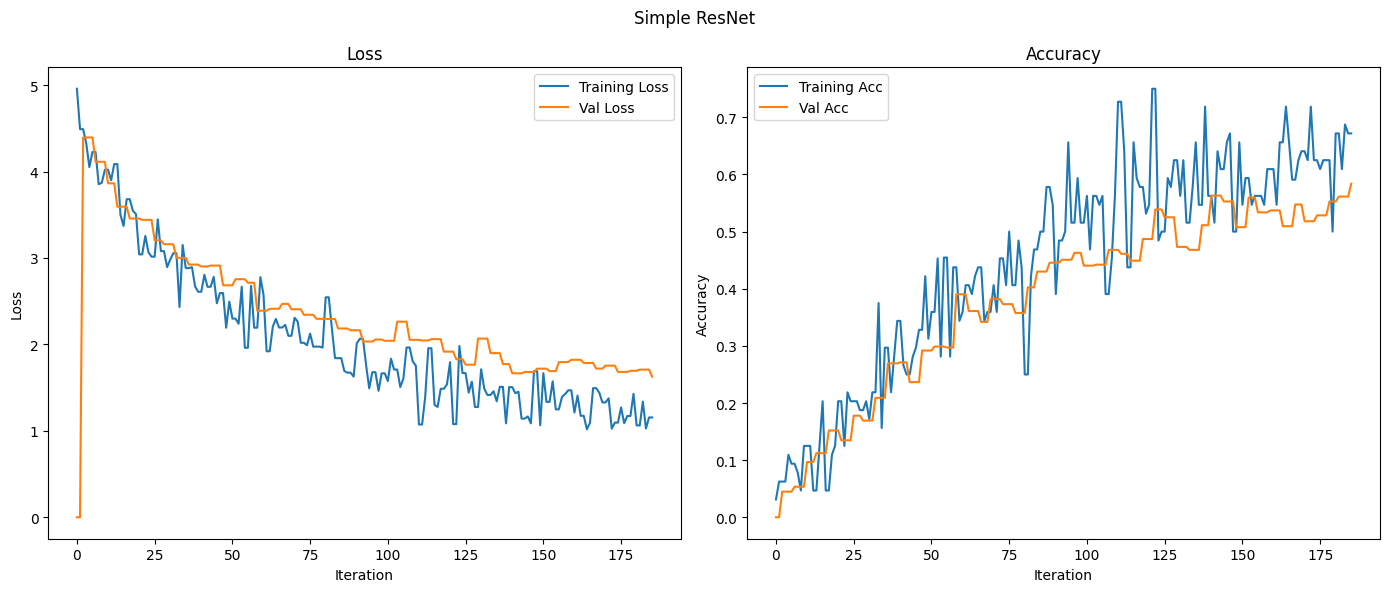

In [21]:
plot_graph_plt_nn(simple_res, "Simple ResNet")

### 3.b

In [17]:
class ResidualBlockNoIdentity(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([channels, 56, 56])
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([channels, 56, 56])

    def forward(self, x):
        # identity = x
        out = F.relu(self.ln1(self.conv1(x)))
        out = self.ln2(self.conv2(out))
        out = F.relu(out)
        return out


In [18]:
model = SimpleResNet(num_blocks=18, num_classes=CLASS, block_class=ResidualBlockNoIdentity)

In [23]:
csv_logger = CSVLogger("logs_flower", name="flower_Simple_ResNet_No_Identity")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    # dirpath="checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
    save_last=True,
)

# %%
trainer = L.Trainer(
    callbacks=[checkpoint_callback],
    logger=csv_logger,
    max_epochs=SIMPLE_RES_EPOCHS,
    # fast_dev_run=True,
    log_every_n_steps=30,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:
print(model)

SimpleResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (ln1): LayerNorm((64, 112, 112), eps=1e-05, elementwise_affine=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (blocks): Sequential(
    (0): ResidualBlockNoIdentity(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ln1): LayerNorm((64, 56, 56), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ln2): LayerNorm((64, 56, 56), eps=1e-05, elementwise_affine=True)
    )
    (1): ResidualBlockNoIdentity(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ln1): LayerNorm((64, 56, 56), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ln2): LayerNorm((64, 56, 56), eps=1e-05, elementwise_affine=True)
    )
    (2): ResidualBlockNoIdentity(


In [25]:
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | conv1       | Conv2d            | 9.5 K  | train
1 | ln1         | LayerNorm         | 1.6 M  | train
2 | pool        | MaxPool2d         | 0      | train
3 | blocks      | Sequential        | 15.8 M | train
4 | global_pool | AdaptiveAvgPool2d | 0      | train
5 | fc          | Linear            | 6.6 K  | train
----------------------------------------------------------
17.4 M    Trainable params
0         Non-trainable params
17.4 M    Total params
69.607    Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 82/82 [00:20<00:00,  3.93it/s, v_num=0]         

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 82/82 [00:21<00:00,  3.86it/s, v_num=0]


In [26]:
simple_res_no_identity = pd.read_csv("./logs_flower/flower_Simple_ResNet_No_Identity/version_0/metrics.csv")
simple_res_no_identity = simple_res_no_identity.ffill().fillna(0)


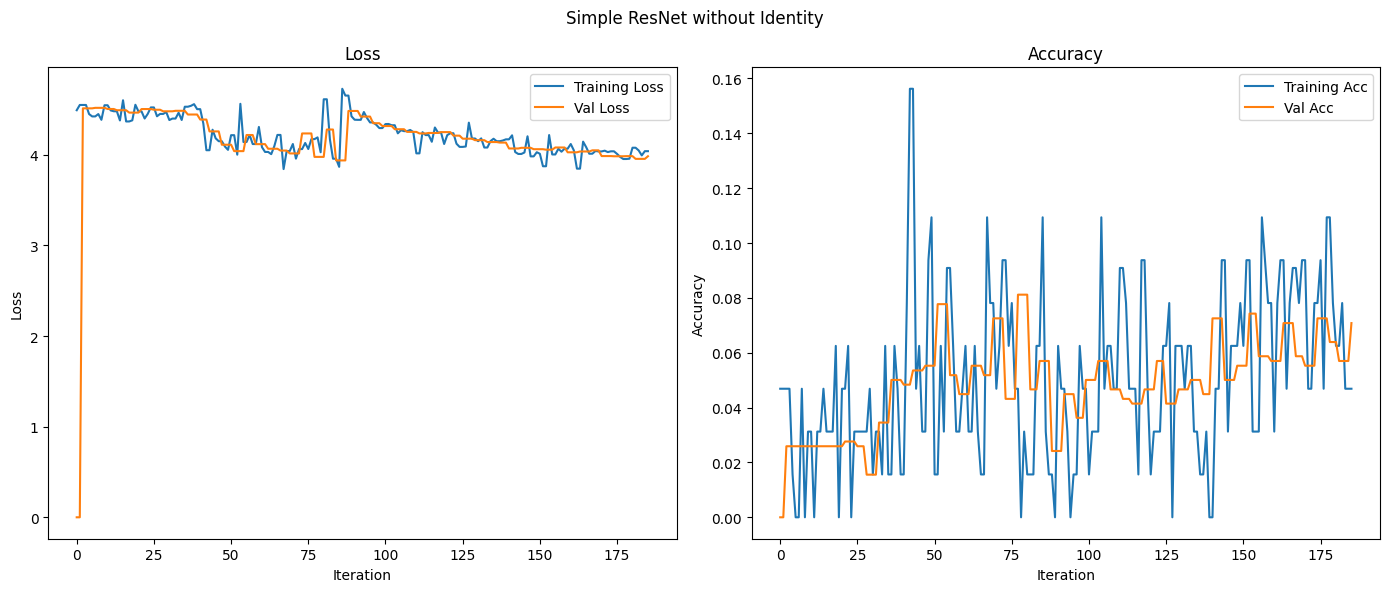

In [27]:
plot_graph_plt_nn(simple_res_no_identity, "Simple ResNet without Identity")

**Comparison and Discussion of ResNet with and without Identity Mapping:**

1. **Training Loss and Accuracy**:
   - **Without Identity Mapping**: The training loss decreases initially but then fluctuates and does not show a clear downward trend. The training accuracy also fluctuates significantly and remains low, indicating that the model is struggling to learn effectively.
   - **With Identity Mapping**: The training loss decreases more consistently and stabilizes at a lower value. The training accuracy shows a clear upward trend, indicating that the model is learning more effectively and steadily improving.

2. **Validation Loss and Accuracy**:
   - **Without Identity Mapping**: The validation loss remains relatively high and fluctuates significantly. The validation accuracy is low and does not improve much, indicating poor generalization to the validation set.
   - **With Identity Mapping**: The validation loss decreases significantly and stabilizes at a lower value. The validation accuracy shows a gradual improvement, indicating better generalization to the validation set.

**Why Identity Mapping is Important in ResNet:**

1. **Mitigating Vanishing Gradients**:
   - Identity mapping helps in mitigating the vanishing gradient problem by providing a direct path for the gradient to flow through the network. This ensures that the gradients do not diminish as they propagate through deeper layers, allowing the model to learn effectively.

2. **Easier Optimization**:
   - The identity mapping allows the network to learn residual functions instead of the original unreferenced functions. This makes the optimization problem easier, as the network only needs to learn the residuals (differences) from the identity mapping, which are often smaller and easier to learn.

3. **Improved Convergence**:
   - With identity mapping, the network can converge faster and more reliably. The direct paths created by identity mappings help in stabilizing the training process, leading to better performance and faster convergence.

**Discussion**:
- The provided learning curves clearly show that the ResNet with identity mapping performs significantly better than the one without. The identity mapping helps in stabilizing the training process, improving both training and validation performance, and ensuring better generalization.

## Part 3

In [11]:
import os
from collections import defaultdict
def count_files_in_folders(root_dir:Path)->dict:
    # Dictionary to store folder counts
    folder_counts = {}

    # Walk through all directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Get the immediate parent folder name
        folder_name = os.path.basename(dirpath)
        # Count all files in this directory
        num_files = len(filenames)
        if num_files > 0:  # Only count folders that contain files
            folder_counts[int(folder_name)] = num_files

    return dict(sorted(folder_counts.items()))


# https://blog.csdn.net/qq_27095227/article/details/103775032
def get_cross_entry_weights(folder_counts:dict) -> list[float]:
    total_samples = sum(folder_counts.values())
    num_classes = len(folder_counts)
    class_weights = {
        class_id: total_samples / (num_classes * count) 
        for class_id, count in folder_counts.items()
    }

    # 將權重轉換為 tensor 並標準化
    weights = torch.tensor(list(class_weights.values()), dtype=torch.float)
    weights = weights / weights.sum()
    
    return weights.tolist()


In [15]:
########################################################################
# Definition of BasicBlock（使用兩個 3x3 卷積）：
########################################################################
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes: int, planes: int, stride: int = 1, dropout: float = 0.0):
        super(BasicBlock, self).__init__()
        # 第一個卷積層：3x3 卷積，可調整尺寸（透過 stride）
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # 第二個卷積層：3x3 卷積，保持尺寸
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.dropout = nn.Dropout(dropout)

        # 若輸入與輸出尺寸不一致，使用 1x1 卷積調整（shortcut path）
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

########################################################################
# 定義 ResNet18：使用 ResNet 原始設計（預設 ImageNet 輸入 224x224）
########################################################################
class ResNet(L.LightningModule):
    BLOCK = BasicBlock
    def __init__(
        self, 
        num_blocks: list[int], 
        num_classes: int = 102, 
        ce_weights: list[float] = None, 
        t_max: int = 50,
        dropout: float = 0.0
    )->None:
        super(ResNet, self).__init__()
        self.ce_weights = torch.tensor(ce_weights) if ce_weights is not None else None
        self.t_max = t_max
        self.dropout_rate = dropout
        
        self.in_planes = 64

        # 初始卷積層：7x7 卷積，stride=2，再加 BN 與 ReLU
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # 最大池化：將特徵圖尺寸縮小一半
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 依序建立四層：ResNet18 的配置為 [2, 2, 2, 2] 個 BasicBlock
        self.layer1 = self._make_layer(ResNet.BLOCK, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(ResNet.BLOCK, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(ResNet.BLOCK, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(ResNet.BLOCK, 512, num_blocks[3], stride=2)

        # 全球平均池化層，接全連接層輸出最終分類結果
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * ResNet.BLOCK.expansion, num_classes)
        
        self.save_hyperparameters()

    def _make_layer(self, block, planes: int, num_blocks: int, stride: int):
        layers = []
        # 第一個 block 根據 stride 調整尺寸，其餘 block stride=1
        strides = [stride] + [1] * (num_blocks - 1)
        for s in strides:
            layers.append(block(self.in_planes, planes, s, self.dropout_rate))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷積、BN、ReLU、MaxPool
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        # 四層 Residual 模塊
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # 全球平均池化後攤平
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # 全連接層輸出分類結果
        x = self.fc(x)
        return x
    
    @torch.autocast(device_type="cuda")
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        self.ce_weights = self.ce_weights.to(y.device)
        
        loss = F.cross_entropy(y_hat, y, weight=self.ce_weights)
        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        
        self.log_dict({"train_loss": loss, "train_acc": acc})
        return loss
    
    @torch.autocast(device_type="cuda")
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        self.ce_weights = self.ce_weights.to(y.device)
        
        loss = F.cross_entropy(y_hat, y, weight=self.ce_weights)
        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        
        self.log_dict({"val_loss": loss, "val_acc": acc})
        return 

    @torch.inference_mode()
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)
    
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        # optimizer = optim.RMSprop(self.parameters(), lr=0.01, weight_decay=0.9, momentum=0.9)
        # optimizer = optim.AdamW(self.parameters(), lr=0.01, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.t_max)

        # # 原始 SGD 優化器設定
        # optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

        # # StepLR 每 30 epoch 衰減 0.1 倍學習率
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }

In [16]:
def ResNetVariants(
    version:int = 20, 
    num_classes:int = 10, 
    use_ce_weights:bool=False, 
    dropout:float=0.0, 
    t_max:int=150
)->ResNet:
    # ResNet20 依據原論文：共有 1 個初始卷積層 + 3 層，每層 3 個 BasicBlock，再加上全連接層，總層數為 20
    # ResNet32 依據原論文：共有 1 個初始卷積層 + 3 層，每層 5 個 BasicBlock，再加上全連接層，總層數為 32
     # ResNet44 依據原論文：共有 1 個初始卷積層 + 3 層，每層 7 個 BasicBlock，再加上全連接層，總層數為 44
    ce_weights = None 
    if use_ce_weights:
        folder_count = count_files_in_folders(DATASET_PATH / "train")
        ce_weights = get_cross_entry_weights(folder_count)
    
    number_of_blocks = {
        18 : [2, 2, 2, 2],
        34 : [3, 4, 6, 3],
        101 : [3, 4, 23, 3],
        152 : [3, 8, 36, 3],
    }
    
    return ResNet(
        number_of_blocks[version],
        num_classes,
        ce_weights,
        t_max,
        dropout,
    )

In [17]:
RES_BATCH_SIZE = 16
RES_EPOCHS = 100
RES_WORKER = 4
VERSION = 18
USE_CE_WEIGHTS = True
DROPOUT = 0.5
TOTAL_STEP = 1500

In [18]:
model = ResNetVariants(
    version=VERSION,
    num_classes=CLASS,
    use_ce_weights=USE_CE_WEIGHTS,
    dropout=DROPOUT,
    t_max=TOTAL_STEP,
)

In [19]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
train_transform_plus = A.Compose([
    A.Resize(299, 299),
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=0.1, scale=(0.9, 1.1), rotate=(-30, 30), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
# 驗證和測試：先 Resize 再 CenterCrop 到 600×600
val_transform_plus = A.Compose([
    A.Resize(299, 299),  # 為了 CenterCrop 留出邊緣，先 Resize 到略大尺寸
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_transform_plus = A.Compose([
    A.Resize(299, 299),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [21]:
datamodule = FlowerDataModule(
    dataset_path=DATASET_PATH,
    batch_size=RES_BATCH_SIZE,
    train_val_ration=0.75,
    transform={
        "train": train_transform_plus,
        "val": val_transform_plus,
        "test": test_transform_plus
    },
    worker=RES_WORKER
)

In [22]:
csv_logger = CSVLogger("logs_flower", name=f"flower_ResNet_{VERSION}")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    # dirpath="checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}",
    save_top_k=3,
    mode="min",
    save_last=True,
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min"
)

# %%
trainer = L.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=csv_logger,
    max_epochs=RES_EPOCHS,
    # fast_dev_run=True,
    log_every_n_steps=20,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | conv1   | Conv2d            | 9.4 K  | train
1 | bn1     | BatchNorm2d       | 128    | train
2 | relu    | ReLU              | 0      | train
3 | maxpool | MaxPool2d         | 0      | train
4 | layer1  | Sequential        | 147 K  | train
5 | layer2  | Sequential        | 525 K  | train
6 | layer3  | Sequential        | 2.1 M  | train
7 | layer4  | Sequential        | 8.4 M  | train
8 | avgpool | AdaptiveAvgPool2d | 0      | train
9 | fc      | Linear            | 52.3 K | train
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.915    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Epoch 70: 100%|██████████| 272/272 [00:10<00:00, 26.85it/s, v_num=4]       


In [24]:
# Get the best model checkpoint path from the ModelCheckpoint callback
best_model_path = checkpoint_callback.best_model_path
print("Best model checkpoint path:", best_model_path)


Best model checkpoint path: logs_flower/flower_ResNet_18/version_4/checkpoints/model-epoch=60-val_loss=0.89-val_acc=0.76.ckpt


In [ ]:
# check_model = ResNet.load_from_checkpoint(best_model_path)

In [25]:
trainer.validate(datamodule=datamodule,ckpt_path='best')

Restoring states from the checkpoint path at logs_flower/flower_ResNet_18/version_4/checkpoints/model-epoch=60-val_loss=0.89-val_acc=0.76.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs_flower/flower_ResNet_18/version_4/checkpoints/model-epoch=60-val_loss=0.89-val_acc=0.76.ckpt


Validation DataLoader 0: 100%|██████████| 91/91 [00:02<00:00, 40.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7615756988525391
        val_loss            0.8897197842597961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.8897197842597961, 'val_acc': 0.7615756988525391}]

In [99]:
output = trainer.predict(datamodule=datamodule,ckpt_path='best')

Restoring states from the checkpoint path at logs_flower/flower_ResNet_18/version_4/checkpoints/model-epoch=60-val_loss=0.89-val_acc=0.76.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded model weights from the checkpoint at logs_flower/flower_ResNet_18/version_4/checkpoints/model-epoch=60-val_loss=0.89-val_acc=0.76.ckpt


Predicting DataLoader 0: 100%|██████████| 94/94 [00:02<00:00, 46.78it/s]


In [104]:
def output_to_csv(predict:torch.Tensor, output_path:Path)->None:
    output_tensor = torch.concat(predict)
    answer = torch.argmax(output_tensor, dim=1).tolist()
    
    test_file_list = natsorted((DATASET_PATH / "test").iterdir())
    test_file_list = [str(x).split("/")[-1] for x in test_file_list]
    with open(DATASET_PATH / "cat_to_name.json") as f:
        cat_to_name = json.load(f)
    
    # remapping the class index to class name
    idx_to_class = {
        v: cat_to_name[k] 
        for k, v in datamodule.train_dataset.dataset.class_to_idx.items()
    }
    
    answer = [idx_to_class[x] for x in answer]
    result = pd.DataFrame({"ID": test_file_list, "Category": answer})
    result.to_csv(output_path, index=False)
    return

In [105]:
output_to_csv(output, "submission.csv")

In [23]:
res_var = pd.read_csv(f"./logs_flower/flower_ResNet_{VERSION}/version_1/metrics.csv")
res_var= res_var.ffill().fillna(0)


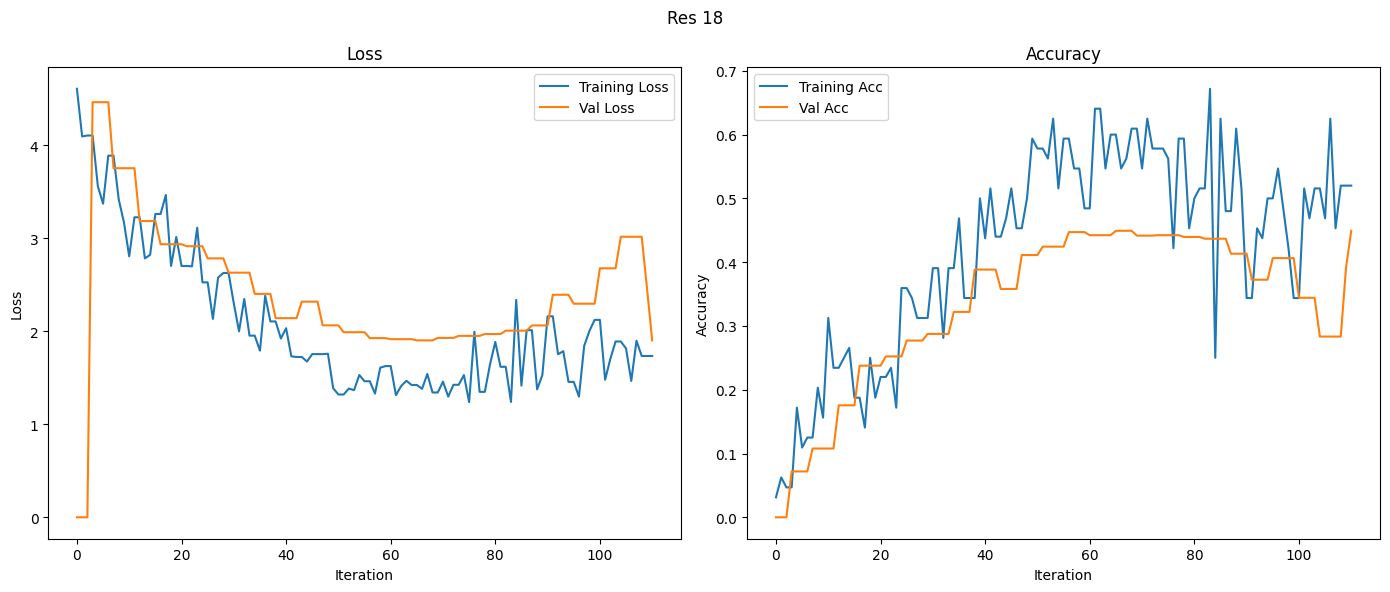

In [24]:
plot_graph_plt_nn(res_var, f"Res {VERSION}")